# Forecasting Driver Attrition for OLA

#### Problem Statement
Ola faces a persistent challenge in retaining its driver workforce. The high churn rate not only disrupts operational continuity but also increases recruitment costs and affects service quality. Drivers frequently exit the platform or switch to competitors like Uber, often influenced by fare incentives, stagnant income, or lack of career progression. As Ola expands, this turnover threatens to scale into a major operational and financial bottleneck.

#### Business Objective
The primary goal of this analysis is to build a data-driven churn prediction model that identifies drivers at risk of leaving the platform. By uncovering key behavioral, demographic, and performance-related patterns, Ola can:

- Proactively engage and retain high-value drivers.

- Design targeted incentive programs based on churn risk.

- Optimize recruitment efforts by focusing on long-term retention.

- Improve overall driver satisfaction and reduce operational costs.

#### Importing Libraries

In [701]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import datetime
import time
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve,auc

warnings.simplefilter(action='ignore',category=Warning)
# setting the Custom Pallette to have color coding consistent for all charts
custom_palette = ["#b2e061","#7eb0d5","#bd7ebe","#ffb55a","#fd7f6f"]
sns.set_palette(custom_palette)

#### Exploratory Data Analysis

In [702]:
df=pd.read_csv("ola_driver.csv")
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [703]:
# look at the datatypes of the columns
print('#################################################')
print(f'Shape of the dataset is:{df.shape}')
print('#################################################')
print(df.info())
print('#################################################')
print(f'Number of nan/null values in each column: \n{df.isna().sum()}')
print('#################################################')
print(f'Number of unique values in each column: \n{df.nunique()}')
print('#################################################')
print(f'Number of duplicate entries: \n{df.duplicated().value_counts()}')

#################################################
Shape of the dataset is:(19104, 14)
#################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null

In [704]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,19104.0,NaN,NaN,NaN,9551.5,5514.994107,0.0,4775.75,9551.5,14327.25,19103.0
MMM-YY,19104,24,01/01/19,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driver_ID,19104.0,NaN,NaN,NaN,1415.591133,810.705321,1.0,710.0,1417.0,2137.0,2788.0
Age,19043.0,NaN,NaN,NaN,34.668435,6.257912,21.0,30.0,34.0,39.0,58.0
Gender,19052.0,NaN,NaN,NaN,0.418749,0.493367,0.0,0.0,0.0,1.0,1.0
City,19104,29,C20,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Level,19104.0,NaN,NaN,NaN,1.021671,0.800167,0.0,0.0,1.0,2.0,2.0
Income,19104.0,NaN,NaN,NaN,65652.025126,30914.515344,10747.0,42383.0,60087.0,83969.0,188418.0
Dateofjoining,19104,869,23/07/15,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LastWorkingDate,1616,493,29/07/20,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Understandiing data distribution across categorical columns

In [705]:
# Non-numeric columns
obj_cols = df.select_dtypes(include='object').columns

for col in obj_cols:
    print()
    print(f'Total Unique Values in {col} column are :- {df[col].nunique()}')
    percent=df[col].value_counts(normalize=True)*100
    percent=percent[percent>0.1]
    print(f'Value counts in {col} column are :-\n {percent}')
    print()
    print('-'*120)


Total Unique Values in MMM-YY column are :- 24
Value counts in MMM-YY column are :-
 01/01/19    5.349665
02/01/19    4.941374
03/01/19    4.554020
12/01/20    4.287060
10/01/20    4.281826
08/01/20    4.250419
09/01/20    4.234715
07/01/20    4.219012
11/01/20    4.213777
12/01/19    4.161432
04/01/19    4.156198
01/01/20    4.093384
11/01/19    4.088149
06/01/20    4.030570
05/01/20    4.009631
05/01/19    3.999162
09/01/19    3.988693
02/01/20    3.983459
07/01/19    3.962521
08/01/19    3.946817
10/01/19    3.868300
04/01/20    3.815955
06/01/19    3.800251
03/01/20    3.763610
Name: MMM-YY, dtype: float64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in City column are :- 29
Value counts in City column are :-
 C20    5.276382
C29    4.711055
C26    4.548786
C22    4.234715
C27    4.114322
C15    3.983459
C10    3.894472
C12    3.805486
C8     3.726968
C16    3.711265
C28    3.575168
C

### EDA Summary:

- The dataset comprises 19,104 entries across 14 features.

- Among these, 9 columns are numerical (float/int) and 4 are categorical (object type).

- No duplicate records are present in the dataset.

- The presence of a value in the LastWorkingDate column indicates that the driver has exited the company.
- There are 61 missing values in Age and 52 in Gender, which require imputation.

- The Unnamed: 0 column serves as a sequential index and can be safely removed.

- The Driver_ID column is a unique identifier and does not contribute to predictive modeling, so it can be dropped.

- Based on data types and cardinality, the following are categorical variables: Gender, City, Education_Level, Joining Designation, Quarterly Rating, and Grade.

- The columns Age, Income, and Total Business Value are classified as numerical variables.

- A new target variable Churn can be derived from the LastWorkingDate column to indicate whether a driver has left the platform.
-City C20 has highest driver concentration and churn rate and may need localized retention strategies.

### Handling Missing Values

In [706]:
age_imputer=KNNImputer()
df[['Age']] = KNNImputer().fit_transform(df[['Age']])

In [707]:
gen_imputer=KNNImputer()
df[['Gender']] = KNNImputer().fit_transform(df[['Gender']])

In [708]:
df.isna().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

### Transformation of columns:

In [709]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [710]:
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'])
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'])

In [711]:
df.rename(columns={'MMM-YY':'ReportingDate'},inplace=True)

### Feature Engineering:

In [712]:
qtr_rating_first=(df.groupby('Driver_ID').agg({'Quarterly Rating':'first'}).astype(int)).reset_index()
qtr_rating_last=(df.groupby('Driver_ID').agg({'Quarterly Rating':'last'}).astype(int)).reset_index()
income_first=(df.groupby('Driver_ID').agg({'Income':'first'}).astype(int)).reset_index()
income_last=(df.groupby('Driver_ID').agg({'Income':'last'}).astype(int)).reset_index()
churn=df.groupby('Driver_ID').agg({'LastWorkingDate':'last'}).isna().reset_index()
churn['LastWorkingDate']=churn['LastWorkingDate'].replace({True:'0',False:'1'})
churn=churn.rename(columns={'LastWorkingDate':'Churn'})

In [713]:
final_df=churn
final_df=final_df.merge(qtr_rating_first,on='Driver_ID')
final_df=final_df.merge(qtr_rating_last,on='Driver_ID')
final_df=final_df.merge(income_first,on='Driver_ID')
final_df=final_df.merge(income_last,on='Driver_ID')

In [714]:
final_df['rating_incr']=np.where(final_df['Quarterly Rating_y']>final_df['Quarterly Rating_x'],1,0)

In [715]:
final_df['income_incr']=np.where(final_df['Income_y']>final_df['Income_x'],1,0)

In [716]:
final_df.drop(columns=['Quarterly Rating_y','Quarterly Rating_x','Income_y','Income_x'],inplace=True)

In [717]:
aggr_list={'ReportingDate':'count',
           'Age':'last',
           'Gender':'first',
           'City':'last',
           'Education_Level':'max',
           'Joining Designation':'first',
           'Dateofjoining':'first',
           'LastWorkingDate':'last',
          'Income':'last',
           'Grade':'mean',
           'Total Business Value':'sum',
          'Quarterly Rating':'last'
          }

In [718]:
processed_df=df.groupby(['Driver_ID']).agg(aggr_list).reset_index()  

In [719]:
final_df=final_df.merge(processed_df,on='Driver_ID')

In [720]:
final_df

,Driver_ID,Churn,rating_incr,income_incr,ReportingDate,Age,Gender,City,Education_Level,Joining Designation,Dateofjoining,LastWorkingDate,Income,Grade,Total Business Value,Quarterly Rating
0,1,1,0,0,3,28.0,0.0,C23,2,1,2018-12-24,2019-03-11,57387,1.0,1715580,2
1,2,0,0,0,2,31.0,0.0,C7,2,2,2020-11-06,NaT,67016,2.0,0,1
2,4,1,0,0,5,43.0,0.0,C13,2,2,2019-12-07,2020-04-27,65603,2.0,350000,1
3,5,1,0,0,3,29.0,0.0,C9,0,1,2019-01-09,2019-03-07,46368,1.0,120360,1
4,6,0,1,0,5,31.0,1.0,C11,1,3,2020-07-31,NaT,78728,3.0,1265000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,0,1,0,24,34.0,0.0,C24,0,2,2015-10-15,NaT,82815,3.0,21748820,4
2377,2785,1,0,0,3,34.0,1.0,C9,0,1,2020-08-28,2020-10-28,12105,1.0,0,1
2378,2786,1,0,0,9,45.0,0.0,C19,0,2,2018-07-31,2019-09-22,35370,2.0,2815090,1
2379,2787,1,0,0,6,28.0,1.0,C20,2,1,2018-07-21,2019-06-20,69498,1.0,977830,1


Transforming categorical features into object data types to enable graphical analysis

In [721]:
final_df.rename(columns={'ReportingDate':'ReportingCount'},inplace=True)
final_df['ReportingCount']=final_df['ReportingCount'].astype('object')
final_df['Education_Level']=final_df['Education_Level'].astype('object')
final_df['Gender']=final_df['Gender'].astype('int')
final_df['Gender']=final_df['Gender'].astype('object')
final_df['Joining Designation']=final_df['Joining Designation'].astype('object')
final_df['Grade']=final_df['Grade'].astype('int')
final_df['Grade']=final_df['Grade'].astype('object')
final_df['Churn']=final_df['Churn'].astype('object')
final_df['rating_incr']=final_df['rating_incr'].astype('object')
final_df['income_incr']=final_df['income_incr'].astype('object')
final_df['Quarterly Rating']=final_df['Quarterly Rating'].astype('object')
final_df['Age']=final_df['Age'].astype('int')
final_df.drop(columns=['Driver_ID'],inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Churn                 2381 non-null   object        
 1   rating_incr           2381 non-null   object        
 2   income_incr           2381 non-null   object        
 3   ReportingCount        2381 non-null   object        
 4   Age                   2381 non-null   int32         
 5   Gender                2381 non-null   object        
 6   City                  2381 non-null   object        
 7   Education_Level       2381 non-null   object        
 8   Joining Designation   2381 non-null   object        
 9   Dateofjoining         2381 non-null   datetime64[ns]
 10  LastWorkingDate       1616 non-null   datetime64[ns]
 11  Income                2381 non-null   int64         
 12  Grade                 2381 non-null   object        
 13  Total Business Val

## Visual Analysis

### Univariate Analysis

i.Categorical Variables

In [722]:
cat_cols=final_df.select_dtypes(include='object').columns

In [723]:
cat_cols

         
#  3   ReportingCount        2381 non-null   object       
#  5   Gender                2381 non-null   object        
#  6   City                  2381 non-null   object        
#  7   Education_Level       2381 non-null   object        
#  8   Joining Designation   2381 non-null   object       
#  12  Grade                 2381 non-null   object         
#  14  Quarterly Rating      2381 non-null   int64 
# 2 date columns for month and year analysis
                
#  4   Age                   2381 non-null   float64       
#  11  Income                2381 non-null   int64               
#  13  Total Business Value  2381 non-null   int64         

Index(['Churn', 'rating_incr', 'income_incr', 'ReportingCount', 'Gender',
       'City', 'Education_Level', 'Joining Designation', 'Grade',
       'Quarterly Rating'],
      dtype='object')

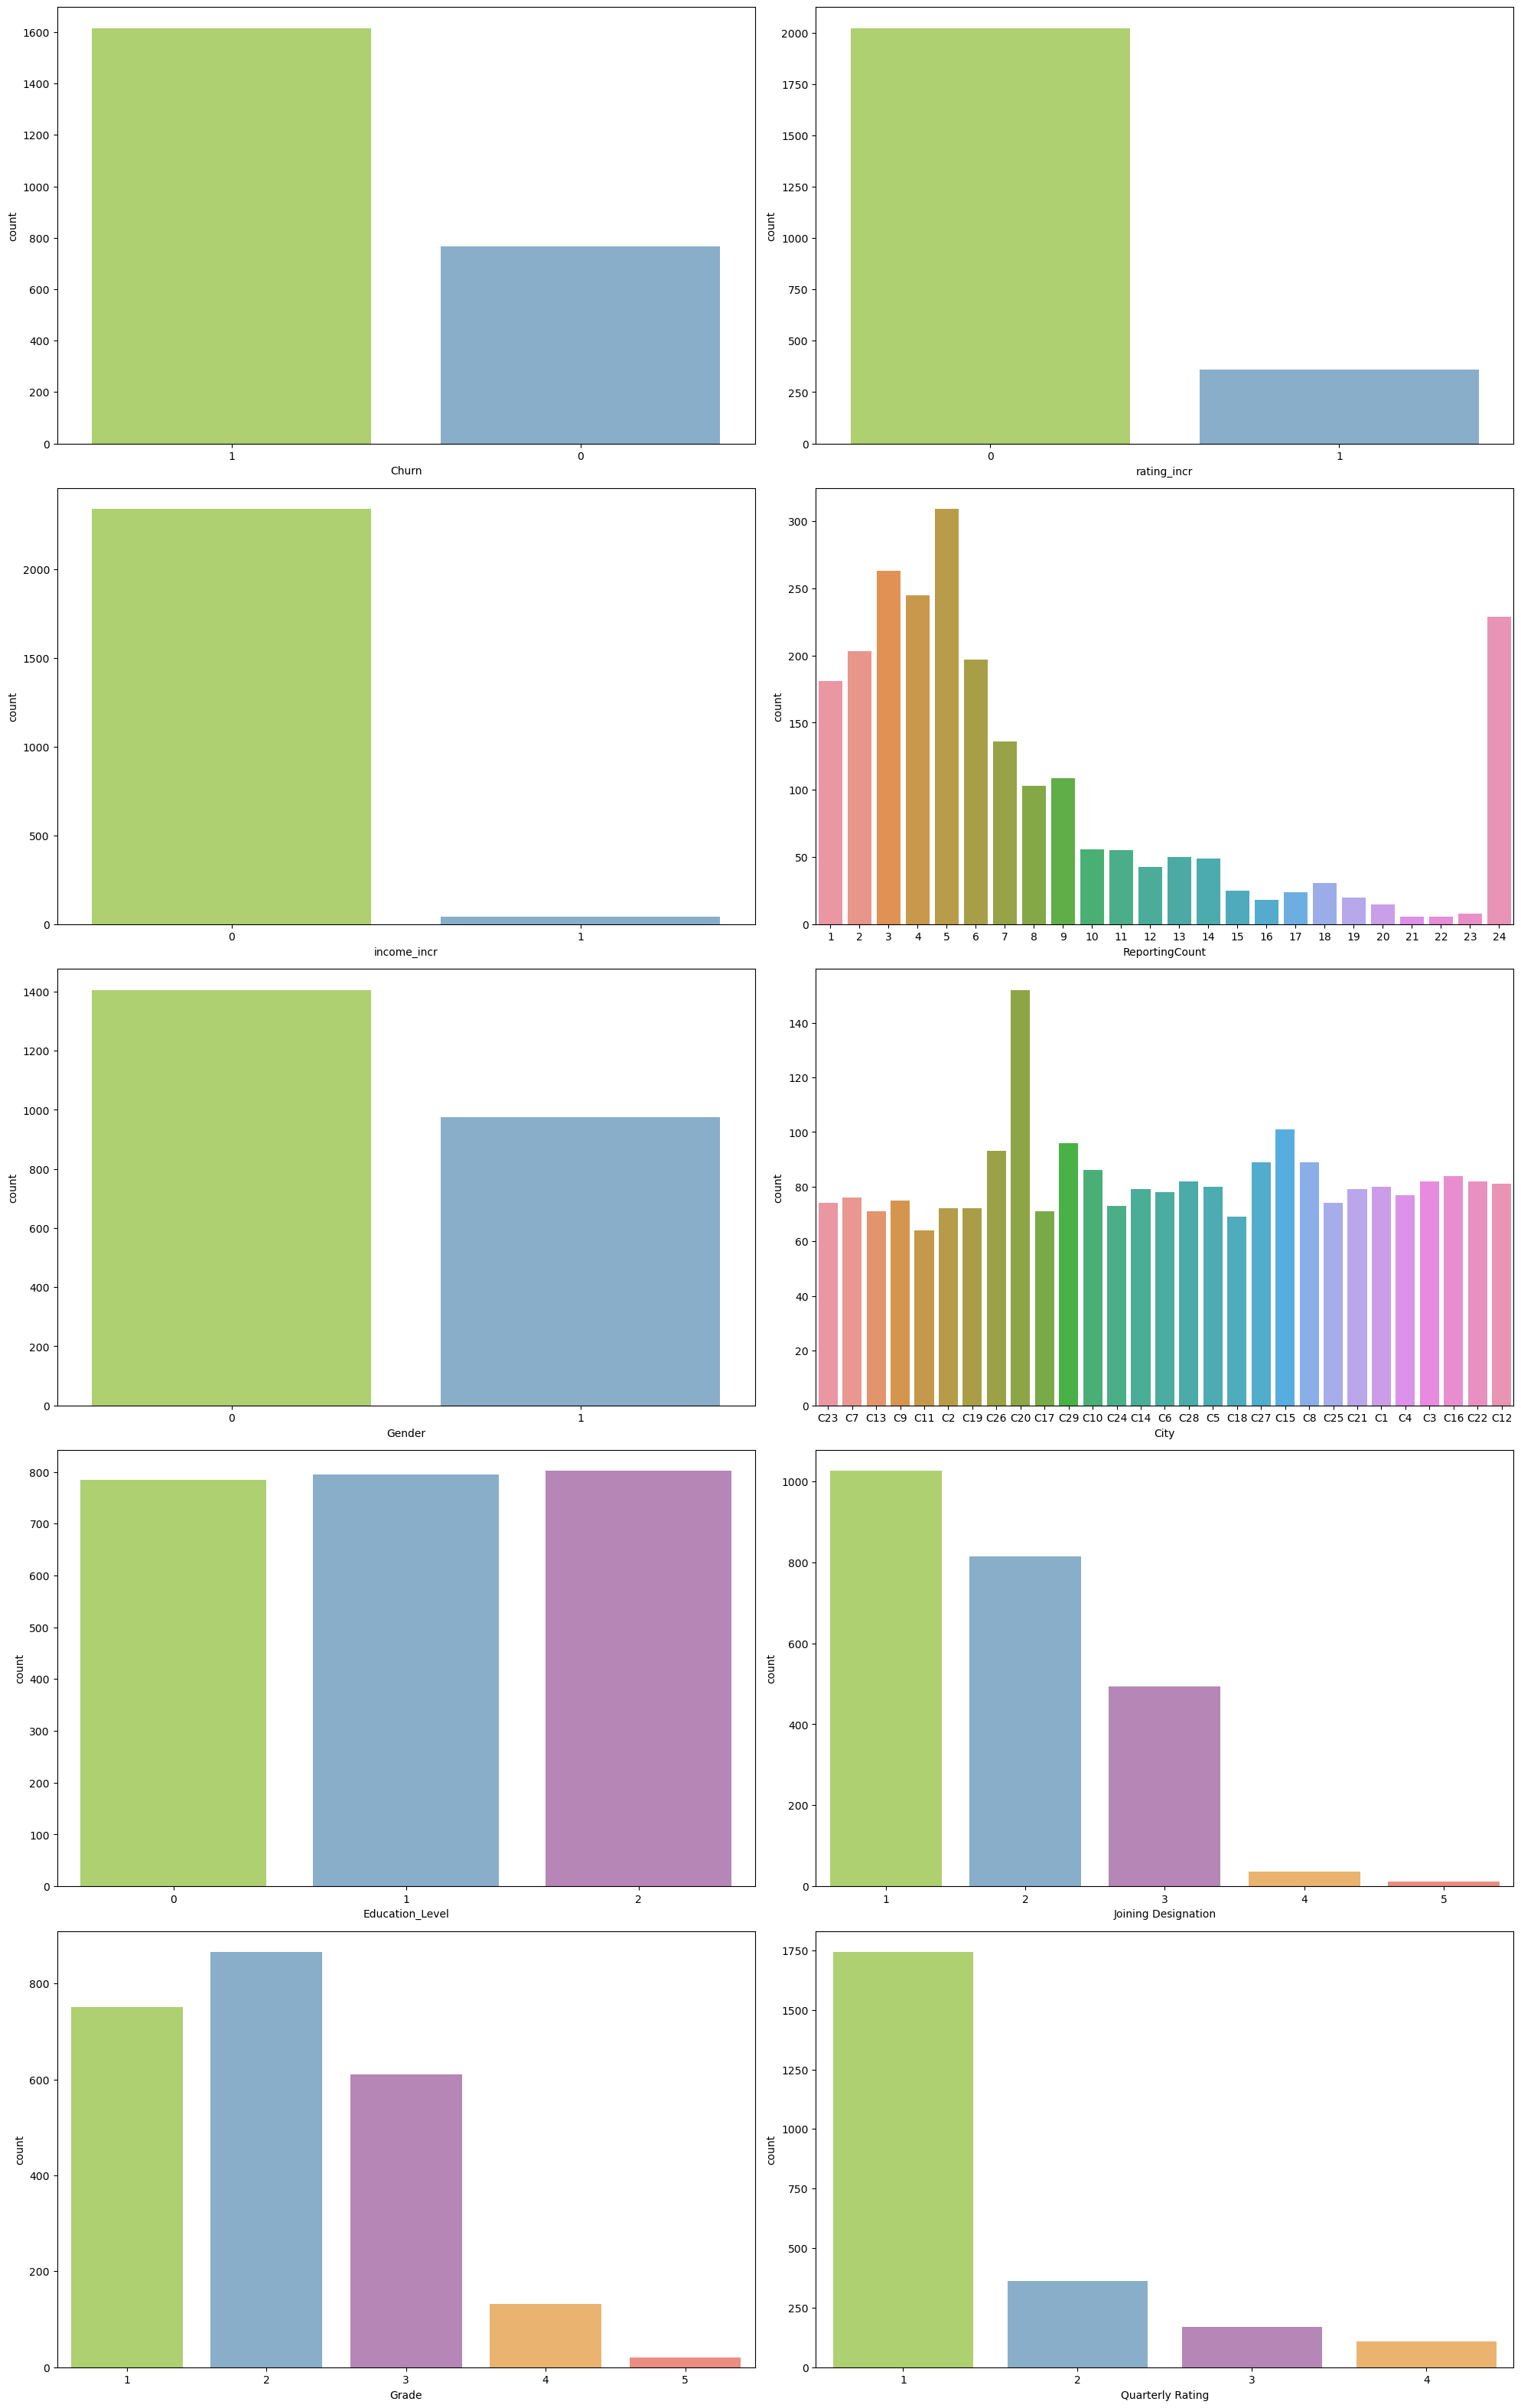

In [724]:
plt.figure(figsize=(20,50))
i=1
for col in cat_cols:
   ax=plt.subplot(8,2,i)
   sns.countplot(final_df[col],ax=ax) 
   i+=1
    
plt.tight_layout()
plt.show()

#### Insights:

- The data indicates a high churn rate among drivers.
- A large proportion of drivers have either maintained consistent ratings or experienced a decline, with only a few showing improvement.
- A large proportion of drivers show no positive change in earnings, suggesting minimal financial growth.
- The most common reporting frequency among drivers is five.
- The driver workforce is predominantly male.
- City C20 accounts for the highest concentration of drivers.
- Educational qualifications among drivers appear evenly distributed.
- A significant portion of drivers joined with designation level 1.
- Grade 2 is the most frequently assigned driver grade.
- Quarterly ratings of 1 are most prevalent across the driver base.

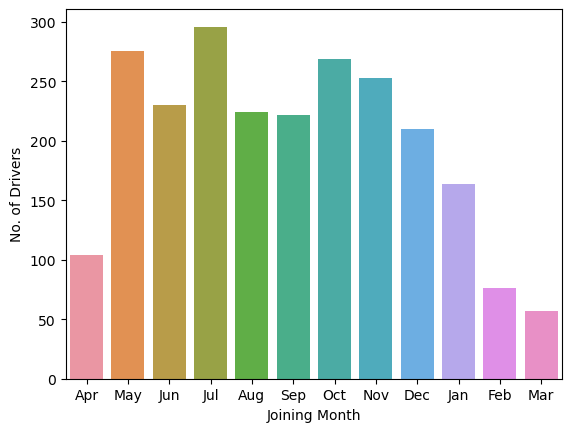

In [725]:
sns.countplot(final_df['Dateofjoining'].sort_values().dt.strftime('%b')) 
plt.xlabel("Joining Month")
plt.ylabel("No. of Drivers")
plt.show()

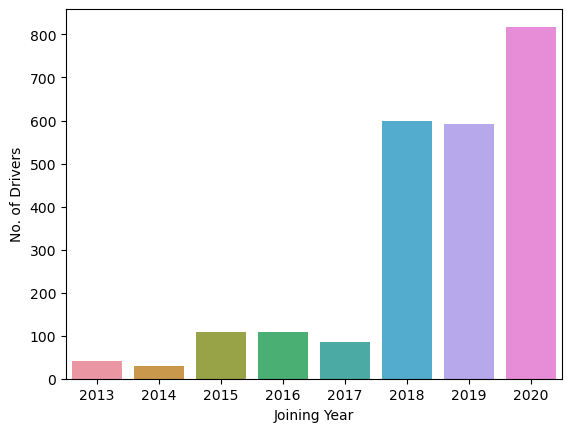

In [726]:
sns.countplot(final_df['Dateofjoining'].sort_values().dt.year) 
plt.xlabel("Joining Year")
plt.ylabel("No. of Drivers")
plt.show()

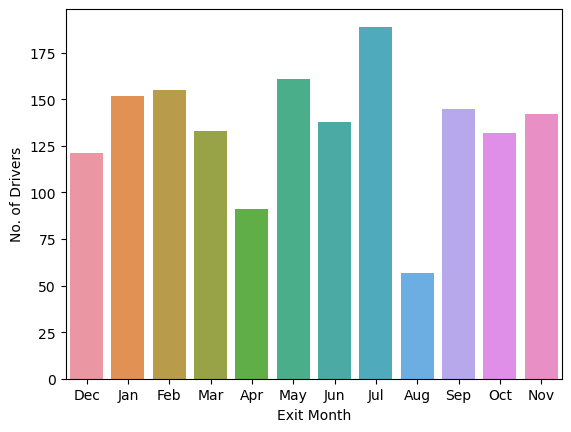

In [727]:
sns.countplot(final_df['LastWorkingDate'].sort_values().dt.strftime('%b')) 
plt.xlabel("Exit Month")
plt.ylabel("No. of Drivers")
plt.show()

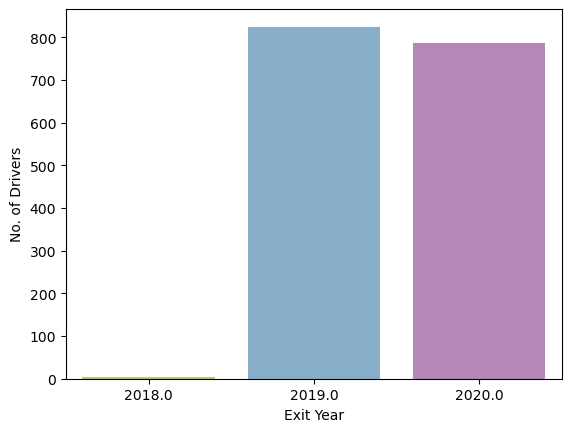

In [728]:
sns.countplot(final_df['LastWorkingDate'].sort_values().dt.year)
plt.xlabel("Exit Year")
plt.ylabel("No. of Drivers")
plt.show()

ii. Continuous Variables

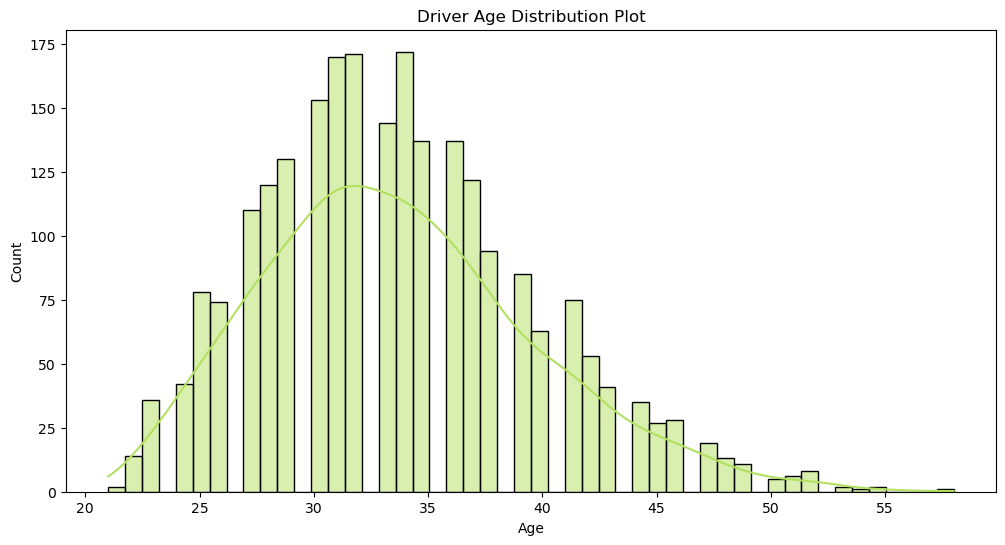

In [729]:
plt.figure(figsize=(12, 6))
sns.histplot(final_df['Age'],kde=True,bins=50,color=custom_palette[0])
plt.title("Driver Age Distribution Plot")
plt.show()

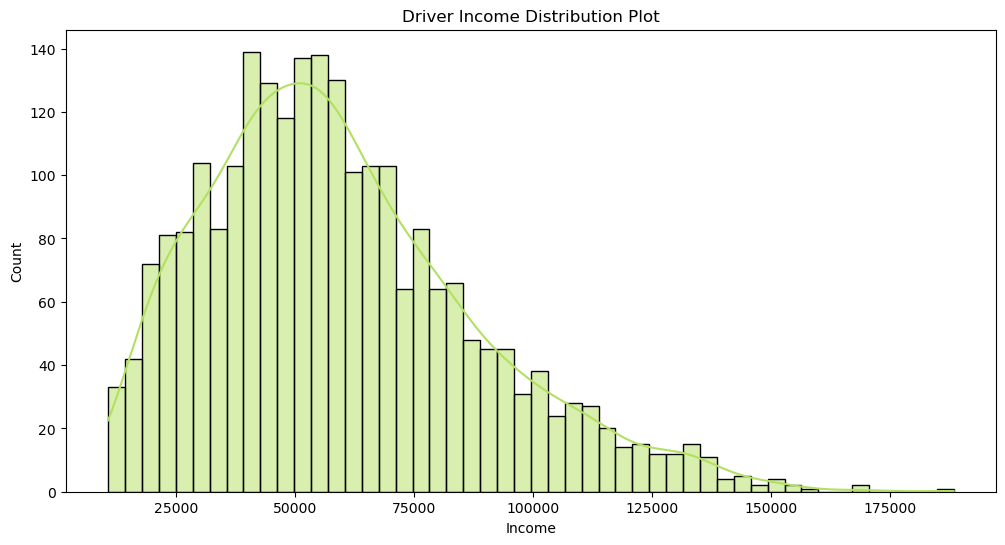

In [730]:
plt.figure(figsize=(12, 6))
sns.histplot(final_df['Income'],kde=True,bins=50,color=custom_palette[0])
plt.title("Driver Income Distribution Plot")
plt.show()

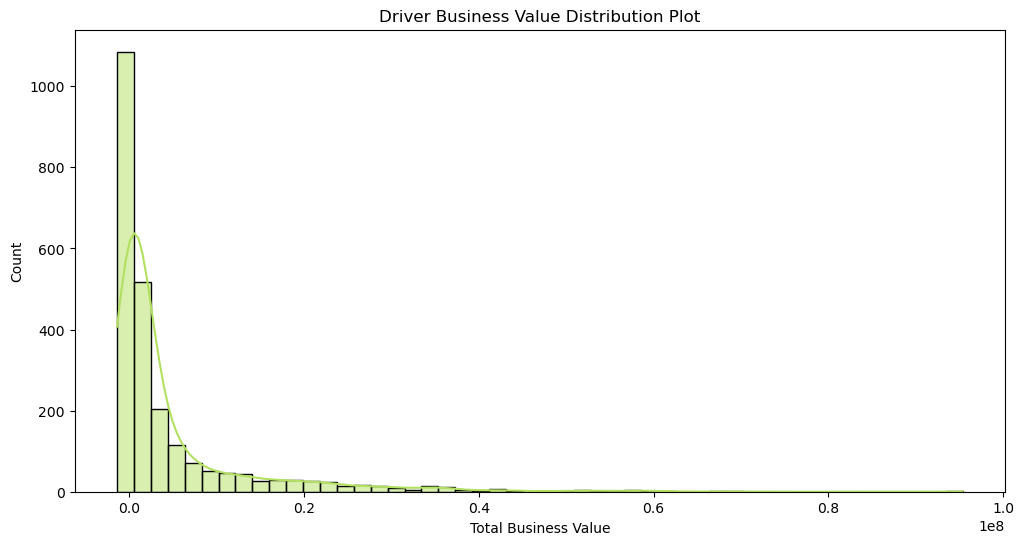

In [731]:
plt.figure(figsize=(12, 6))
sns.histplot(final_df['Total Business Value'],kde=True,bins=50,color=custom_palette[0])
plt.title("Driver Business Value Distribution Plot")
plt.show()

#### Insights:

- Drivers are predominantly in their early 30s, with the average age hovering around 34 years.
- The age range spans from 21 to 58, but the distribution is skewed toward younger drivers, suggesting Ola’s workforce leans youthful.
- There’s a noticeable concentration between ages 30–39, indicating this bracket may be the most active or preferred demographic for recruitment.
- Driver income is heavily concentrated between ₹40,000 and ₹85,000, with a mean around ₹65,000.
- The distribution shows a long tail toward higher incomes, but these are rare suggesting that most drivers earn within a modest bracket.
- A notable number of drivers have zero or even negative business value, which could reflect operational losses, refunds, or data anomalies.
- A small subset of drivers contributes disproportionately to Ola’s business, suggesting that retaining high-value drivers could be critical for financial growth

### Bivariate Analysis

i.Categorical Variables

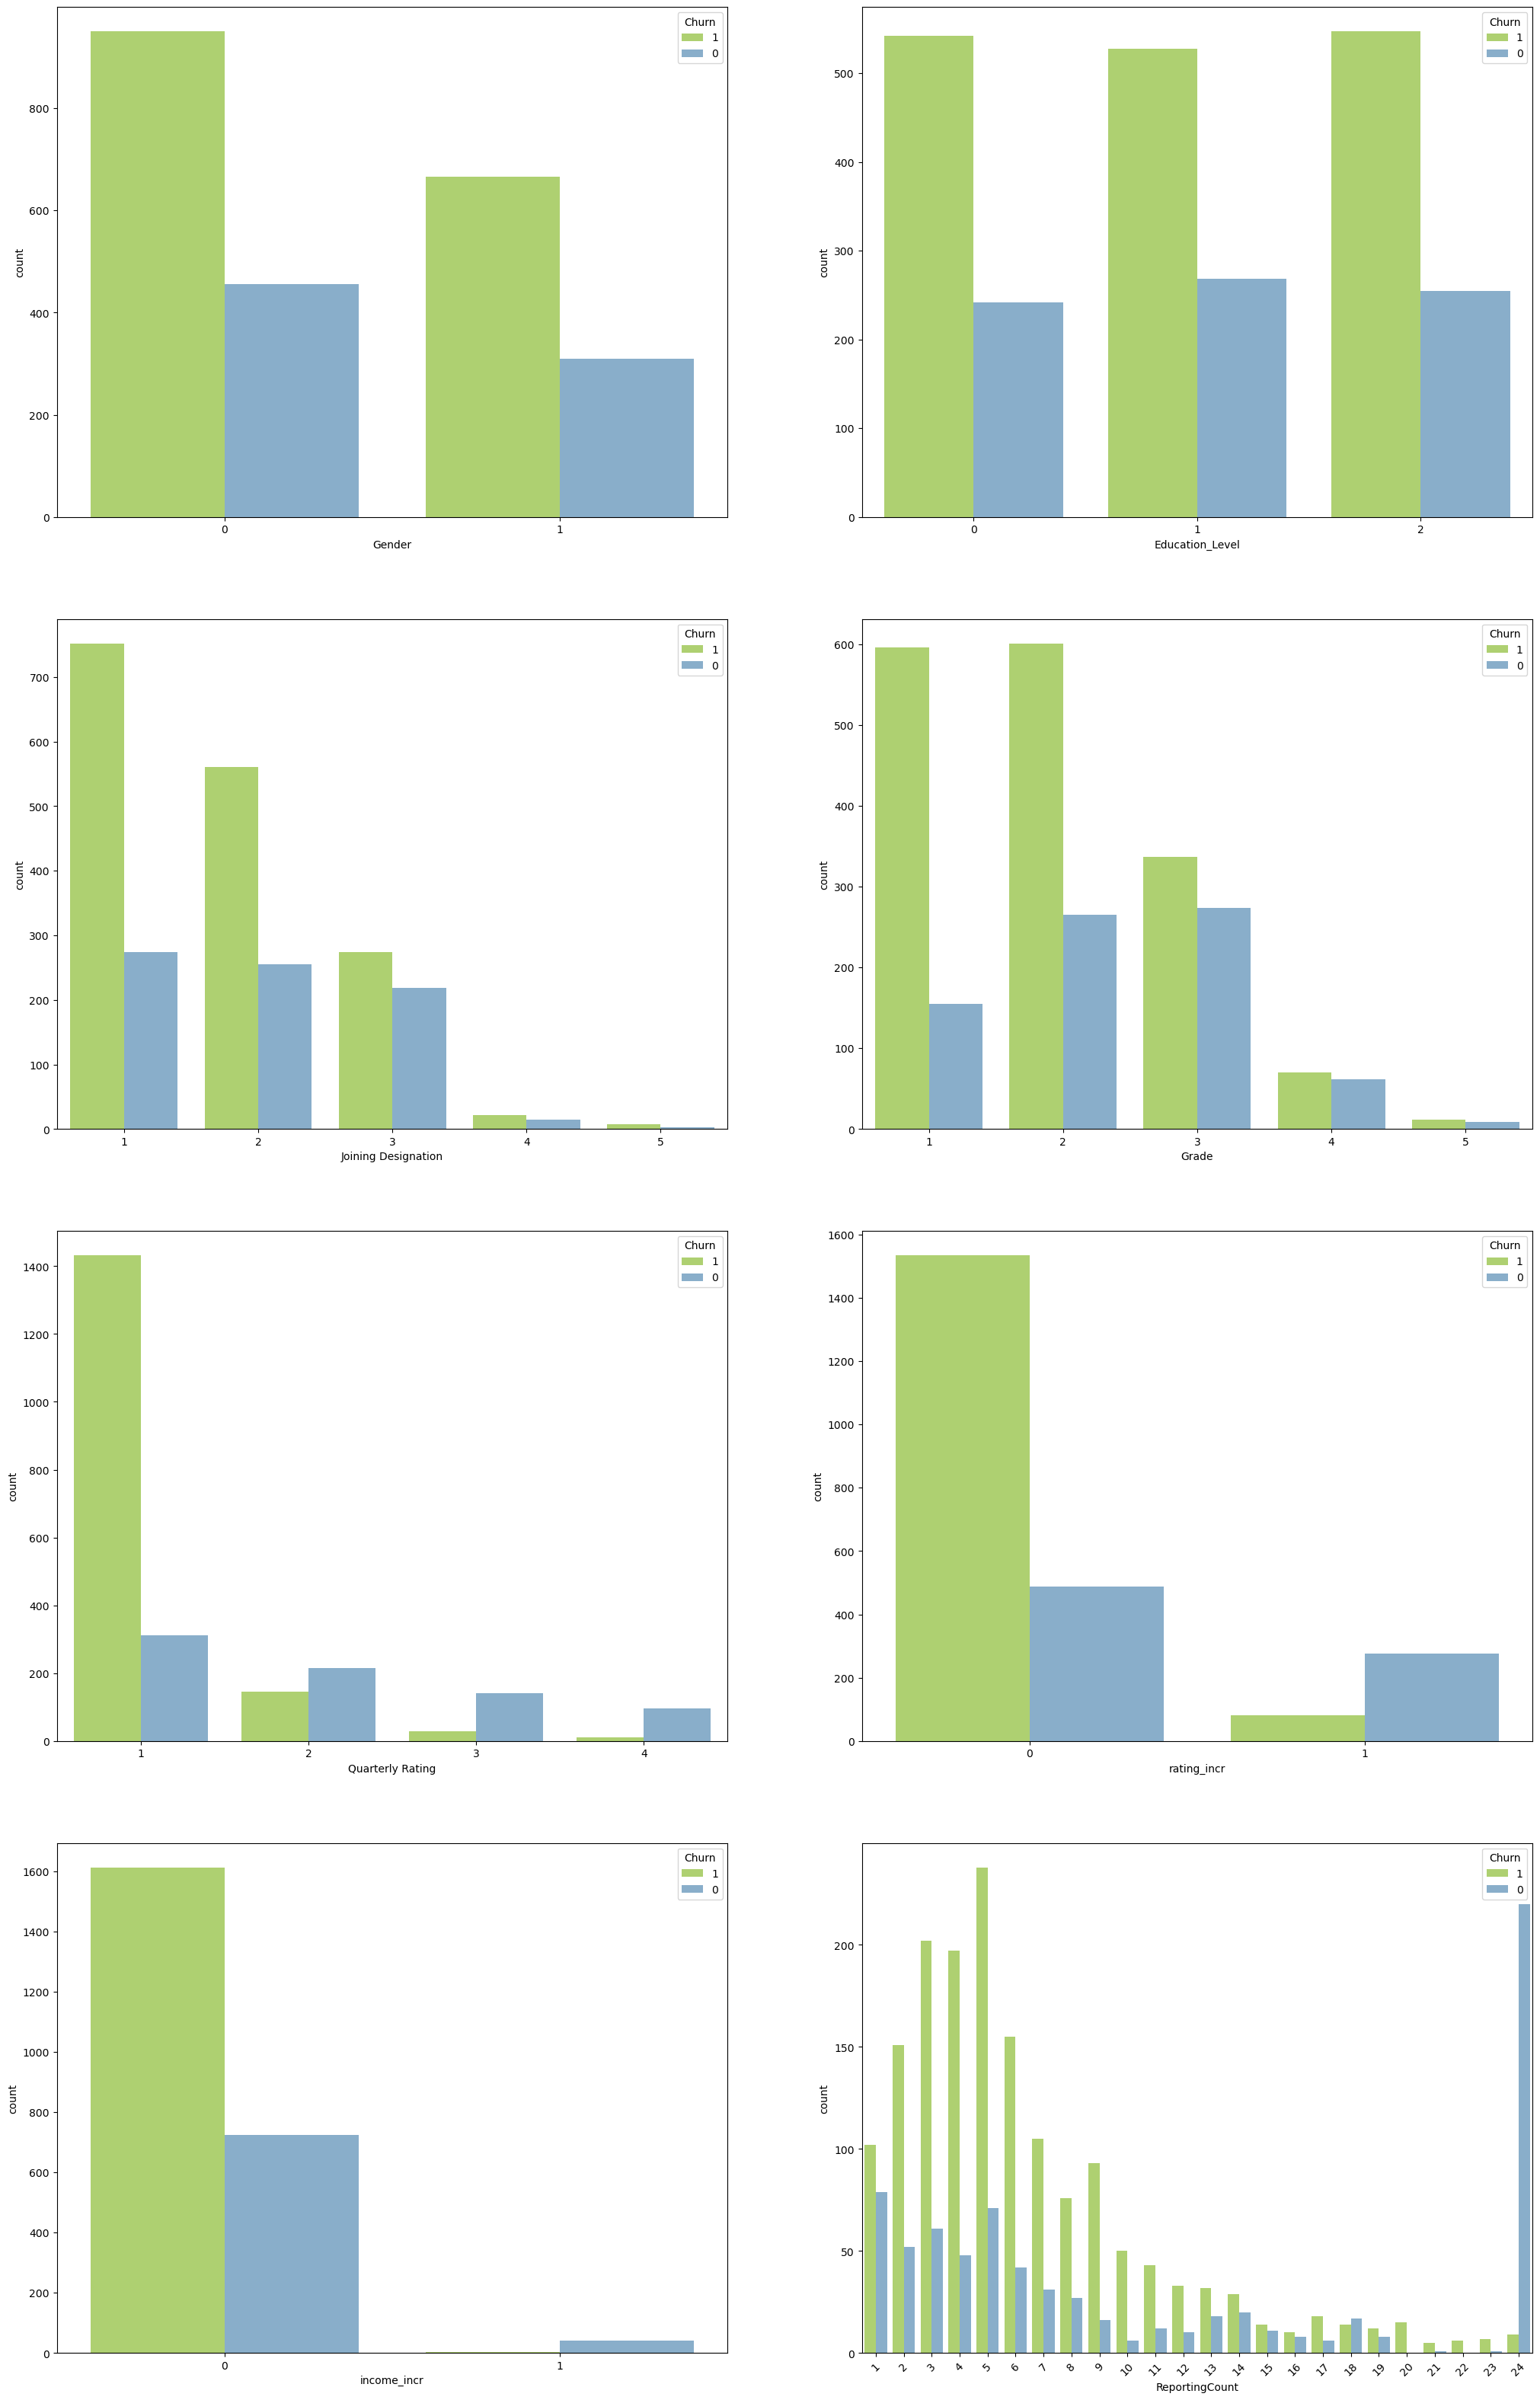

In [732]:
fig,axis= plt.subplots(4,2,figsize=(25,40)) 
sns.countplot(data=final_df,x='Gender',hue='Churn',ax=axis[0,0]) 
sns.countplot(data=final_df,x='Education_Level',hue='Churn',ax=axis[0,1]) 
sns.countplot(data=final_df,x="Joining Designation",hue='Churn',ax=axis[1][0]) 
sns.countplot(data=final_df,x="Grade",hue='Churn',ax=axis[1][1])
sns.countplot(data=final_df,x="Quarterly Rating",hue='Churn',ax=axis[2][0])  
sns.countplot(data=final_df,x="rating_incr",hue='Churn',ax=axis[2][1]) 
sns.countplot(data=final_df,x="income_incr",hue='Churn',ax=axis[3][0])  
sns.countplot(data=final_df,x="ReportingCount",hue='Churn',ax=axis[3][1]) 
plt.xticks(rotation=45)
plt.show() 

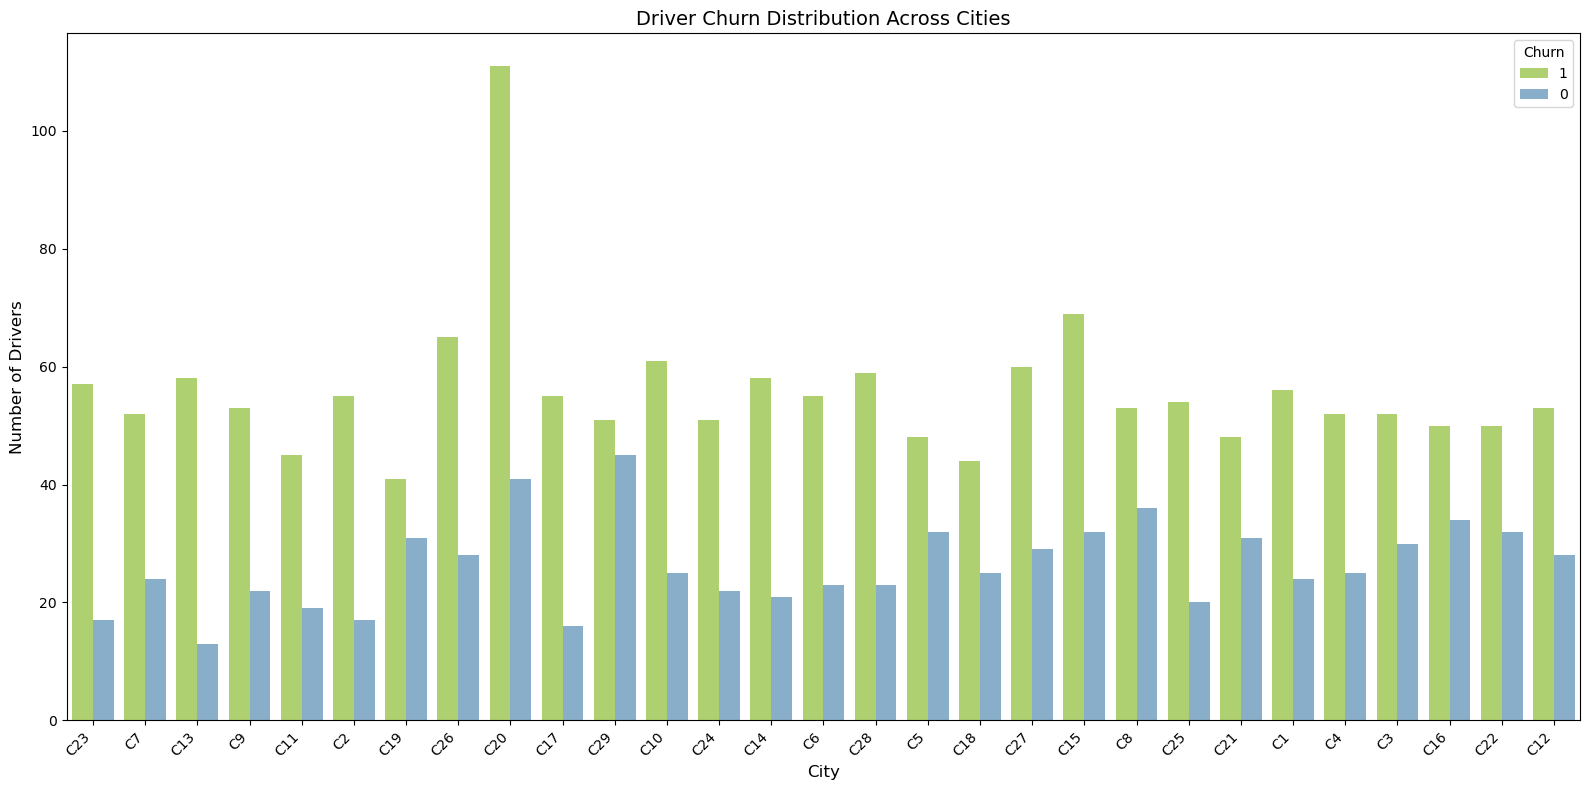

In [733]:
plt.figure(figsize=(16, 8))  # Width=16, Height=8
sns.countplot(data=final_df, x="City", hue="Churn")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel("City", fontsize=12)
plt.ylabel("Number of Drivers", fontsize=12)
plt.title("Driver Churn Distribution Across Cities", fontsize=14)
plt.tight_layout()
plt.show()


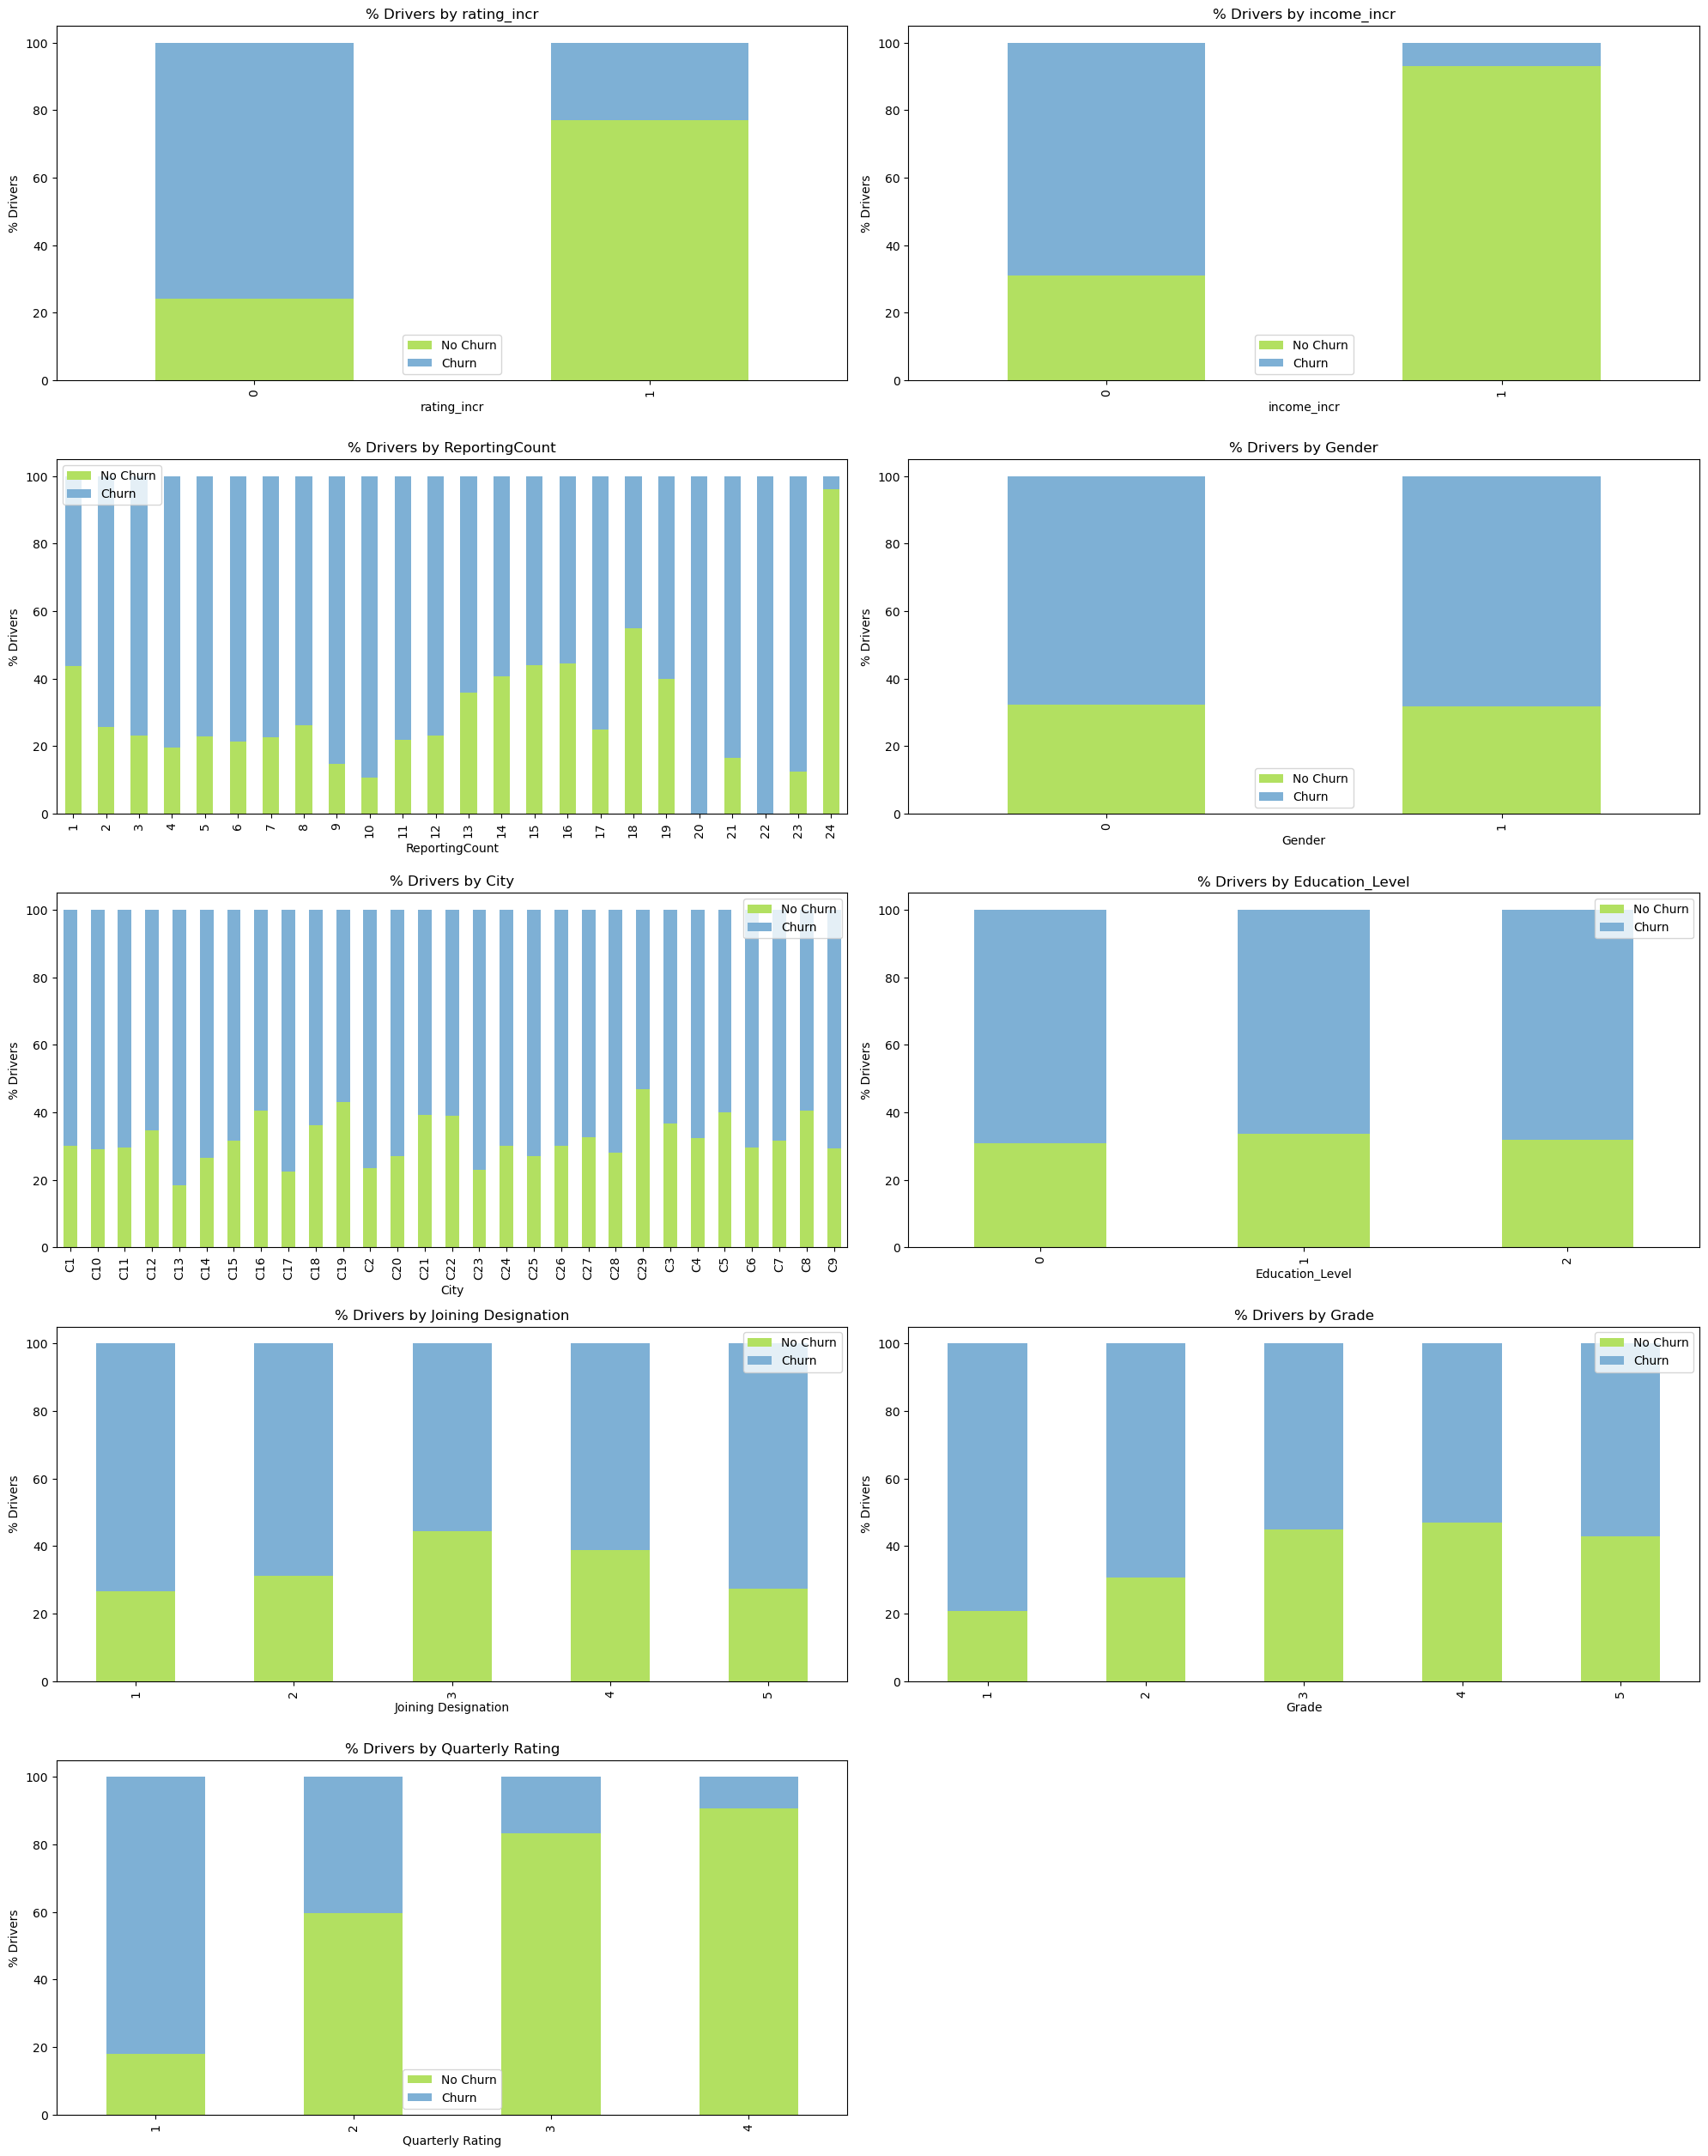

In [734]:
plt.figure(figsize=(20,40))
i=1
for col in cat_cols:
  if col=='Churn':
    continue
  ax=plt.subplot(8,2,i)

  data1=(pd.crosstab(final_df[col],final_df['Churn'],normalize='index')*100)
  data1=data1.round(2)

  data1.plot(kind='bar', stacked=True,ax=ax)
  plt.xlabel(f'{col}')
  plt.ylabel('% Drivers')
  plt.title(f'% Drivers by {col}')
  plt.legend(['No Churn','Churn'])
  i += 1

plt.tight_layout()
plt.show()

#### Insights:
- Gender vs. Churn: Male drivers show a higher churn rate compared to female drivers, suggesting that retention strategies may need to be gender-sensitive.
- Education Level vs. Churn: Churn appears evenly distributed across education levels, indicating that educational background may not be a strong predictor of driver attrition.
- Joining Designation vs. Churn: Drivers who joined at designation level 1 have the highest churn rate, possibly reflecting dissatisfaction or lack of career progression at entry-level positions.
- Grade vs. Churn: Grade 1 drivers show a relatively high churn rate, suggesting that mid-tier performers may be at risk of leaving.
- Quarterly Rating vs. Churn: Drivers with lower ratings (especially rating 1) are more likely to churn, indicating that performance metrics are closely tied to retention.
- Rating Increase vs. Churn: Drivers whose ratings did not improve over time are more likely to churn, reinforcing the idea that lack of growth or recognition contributes to attrition.
- Income Increase vs. Churn: A significant portion of churned drivers did not experience income growth, suggesting that financial stagnation may be a key driver of exit behavior.
- Reporting Count vs. Churn: Drivers with a reporting count of 20 show the highest churn, followed by those with 24, which may reflect operational patterns or workload stress.
- City vs. Churn: City C20 has the highest number of drivers and also a notable churn rate, indicating that geographic location plays a role in driver retention.

ii. Continuous Variables

In [735]:
cat_cols=final_df.select_dtypes(include='number').columns

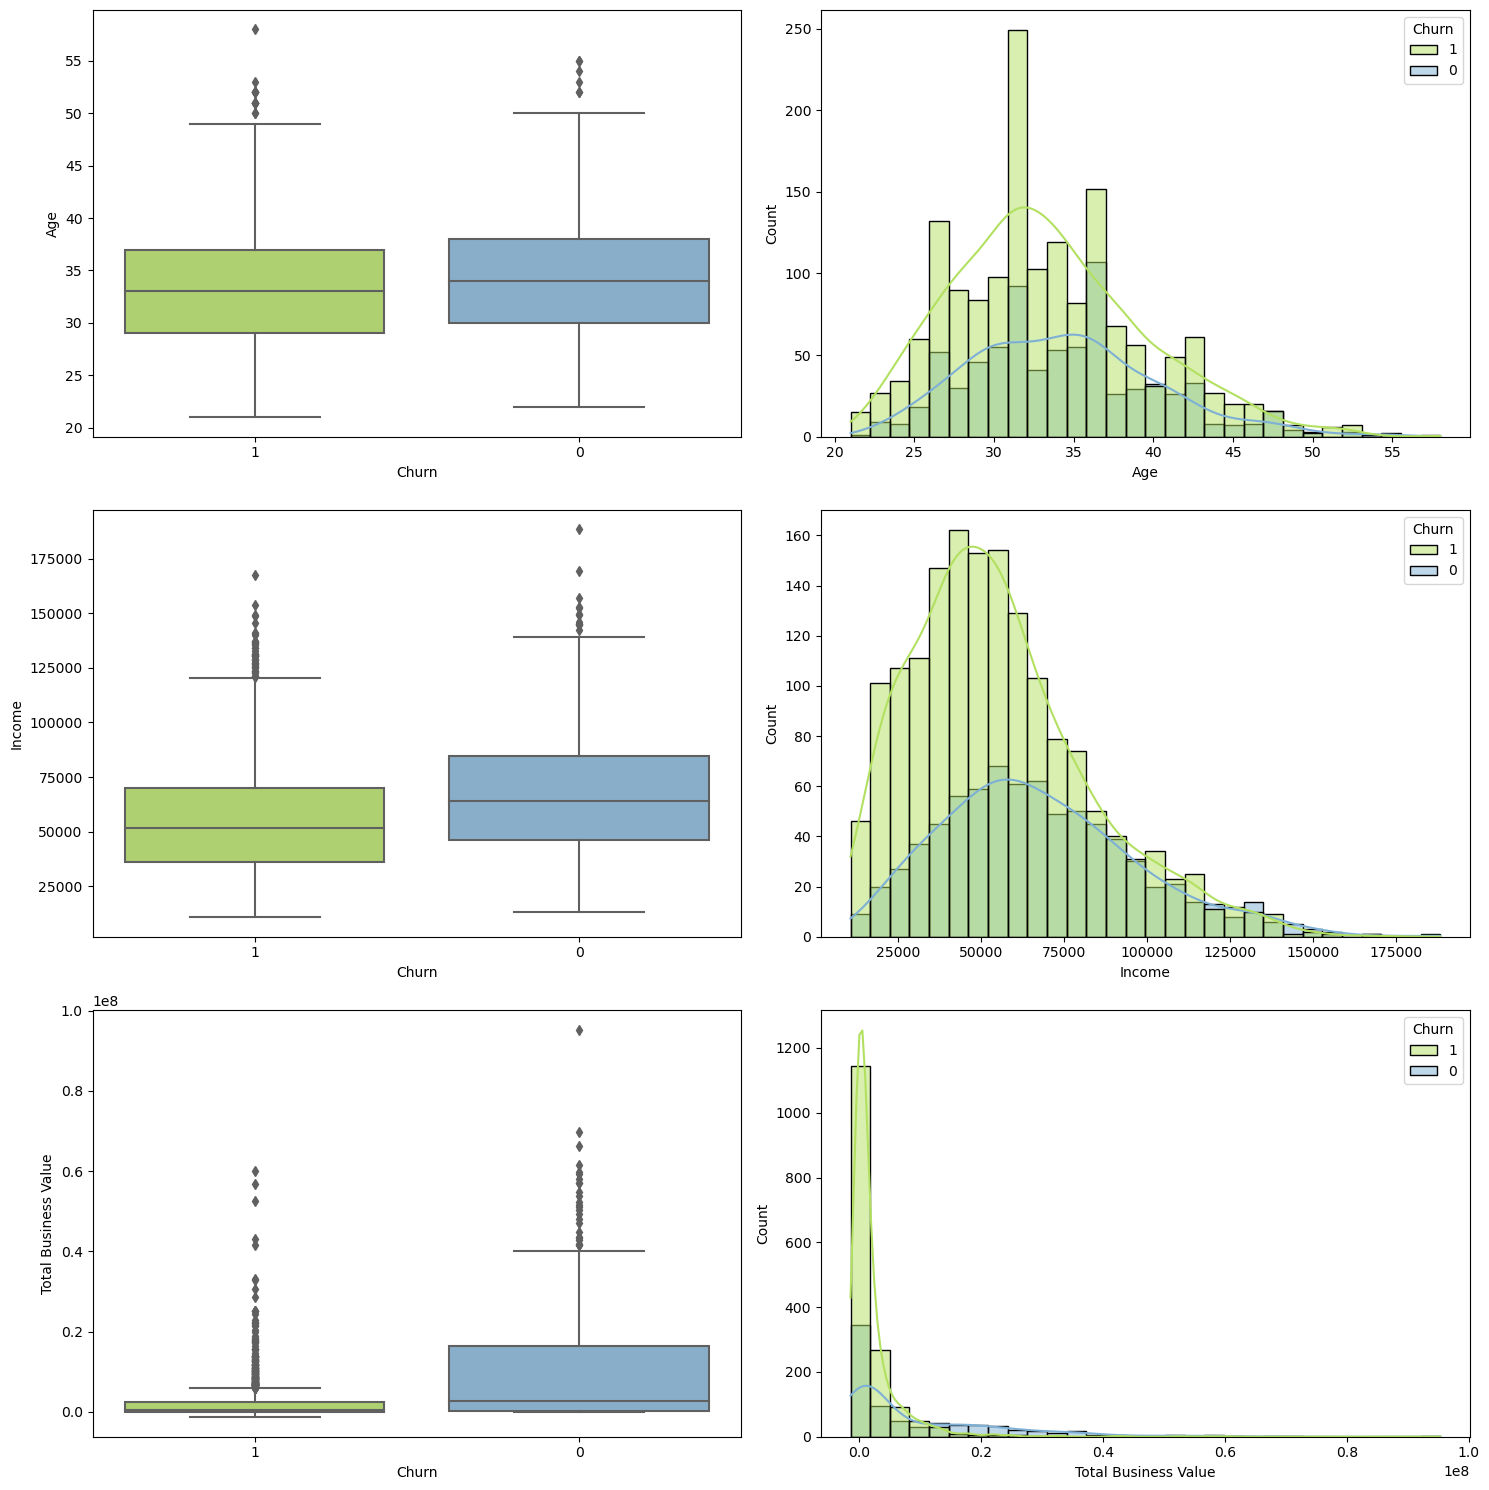

In [736]:
fig, ax = plt.subplots(3,2,figsize=(15,15))
i=0
for col in num_cols:

  sns.boxplot(data=final_df,x="Churn",y=col,ax=ax[i,0]) 
  sns.histplot(data=final_df,x=col,hue='Churn',ax=ax[i,1],kde=True, fill=True,bins=30)
  i += 1

plt.tight_layout()
plt.show()

###### Insights:

- Younger drivers (under 30) show slightly higher churn rates, possibly due to greater job mobility or alternative opportunities.
- Drivers aged 30–39 form the largest group and show moderate churn, suggesting this age bracket is both active and vulnerable.
- Older drivers (above 45) tend to churn less, possibly due to stability or fewer external options.
- Churned drivers generally earn less than retained ones, indicating that financial dissatisfaction may be a key driver of exit behavior.
- The income distribution is skewed, with a few high earners contributing disproportionately to retention.
- Drivers with low or negative business value are more likely to churn, which may reflect poor performance or operational inefficiencies.
- High-value drivers tend to stay, reinforcing the importance of identifying and retaining top contributors.
- A small subset of drivers generates substantial business value, making their retention strategically critical.

City vs Quarterly Rating

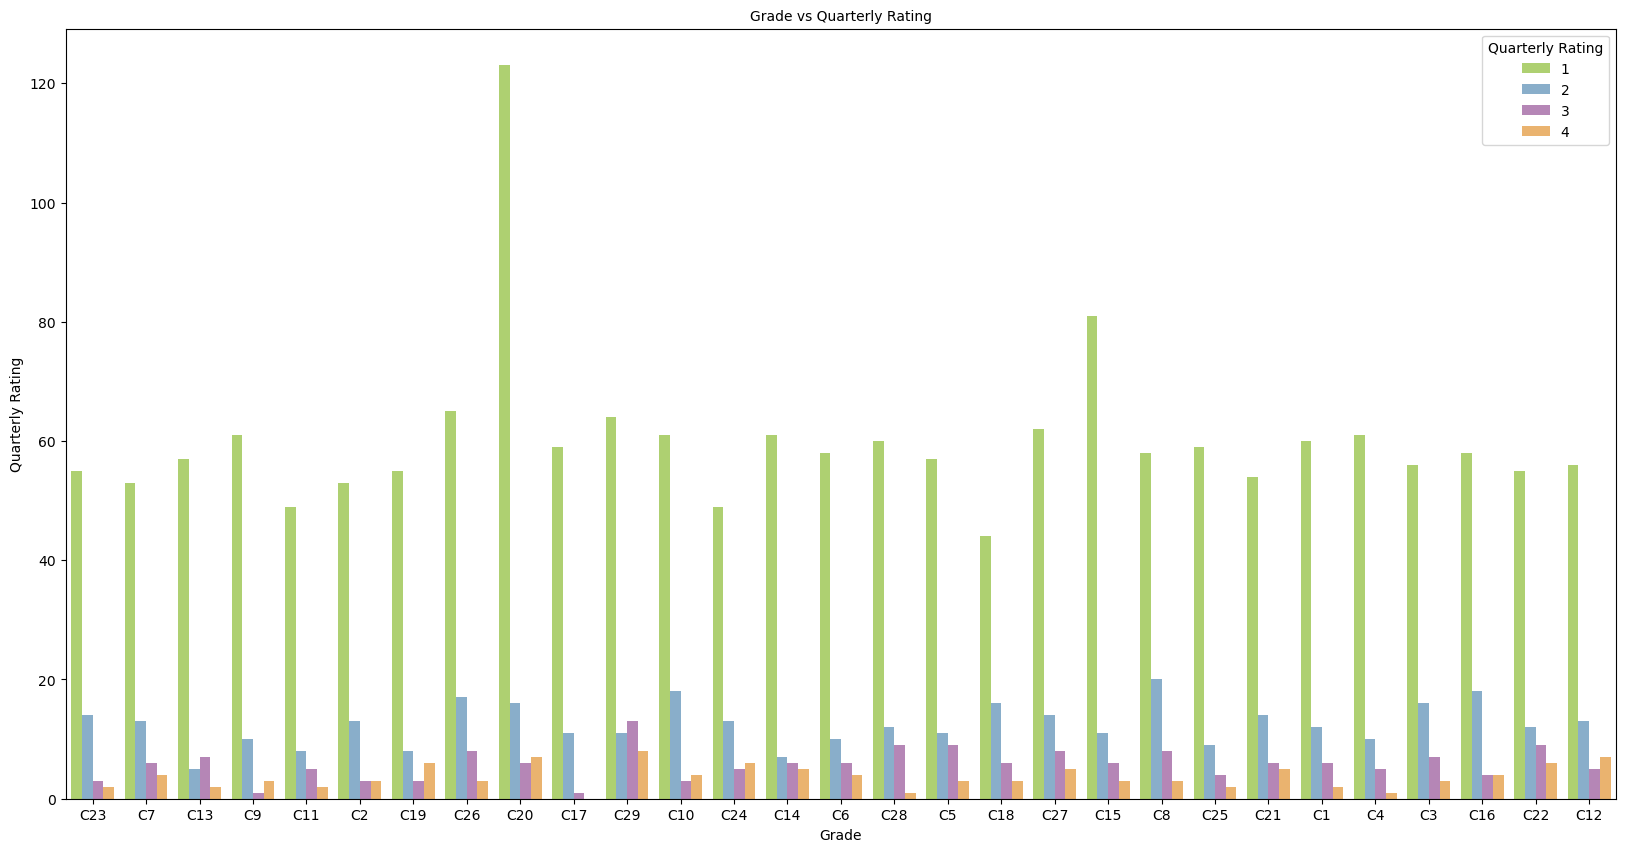

In [737]:
plt.figure(figsize=(20,10))
sns.countplot(data=final_df,x='City',hue='Quarterly Rating')
plt.title('Grade vs Quarterly Rating',fontsize=10)
plt.xlabel('Grade',fontsize=10)
plt.ylabel('Quarterly Rating',fontsize=10)
plt.show() 

City vs Grade

<Figure size 2500x1500 with 0 Axes>

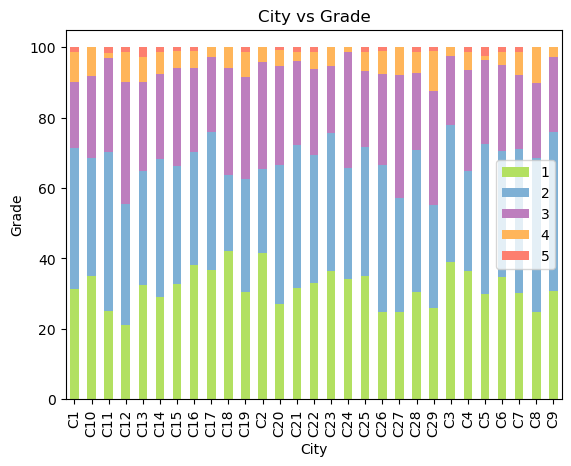

In [738]:
data1=pd.crosstab(final_df['City'],final_df['Grade'],normalize='index')*100
data1=data1.round(2)
plt.figure(figsize=(25,15))
data1.plot(kind='bar', stacked=True)
plt.xlabel('City')
plt.ylabel('Grade')
plt.title('City vs Grade')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
plt.show()

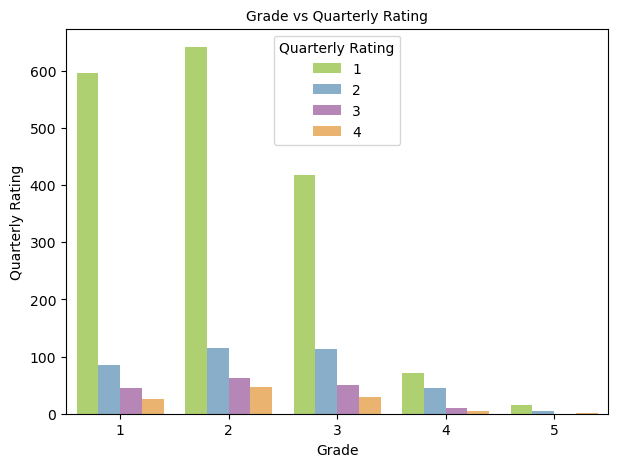

In [739]:
plt.figure(figsize=(7,5))
sns.countplot(data=final_df,x='Grade',hue='Quarterly Rating')
plt.title('Grade vs Quarterly Rating',fontsize=10)
plt.xlabel('Grade',fontsize=10)
plt.ylabel('Quarterly Rating',fontsize=10)
plt.show() 

Grade vs Total business Value

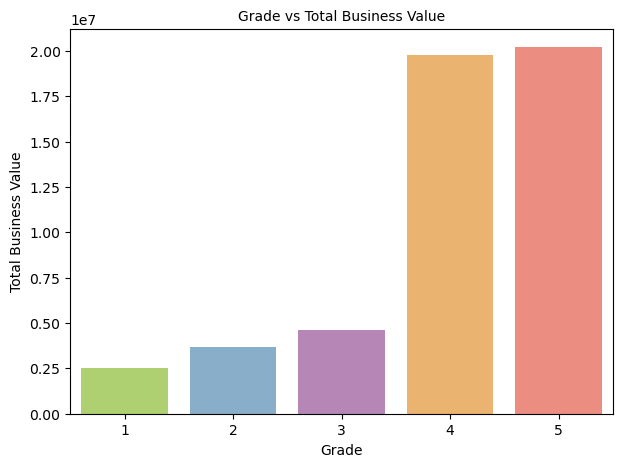

In [740]:
plt.figure(figsize=(7,5))
sns.barplot(data=final_df,x='Grade',y='Total Business Value',ci=None)
plt.title('Grade vs Total Business Value',fontsize=10)
plt.xlabel('Grade',fontsize=10)
plt.ylabel('Total Business Value',fontsize=10)
plt.show() 

Quarterly Rating vs Total business Value

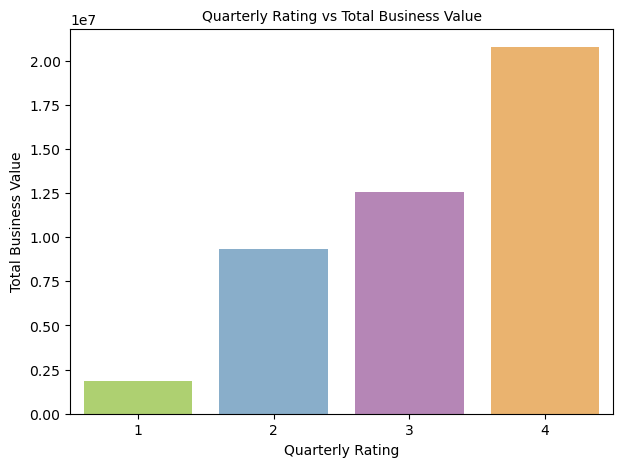

In [741]:
plt.figure(figsize=(7,5))
sns.barplot(data=final_df,x='Quarterly Rating',y='Total Business Value',ci=None)
plt.title('Quarterly Rating vs Total Business Value',fontsize=10)
plt.xlabel('Quarterly Rating',fontsize=10)
plt.ylabel('Total Business Value',fontsize=10)
plt.show() 

Grade vs Income

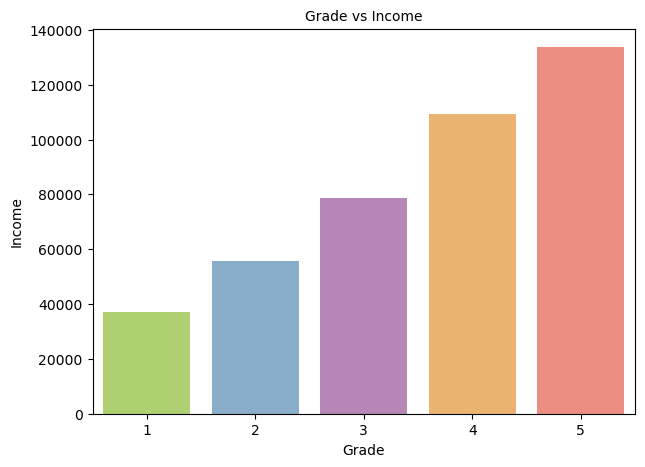

In [742]:
plt.figure(figsize=(7,5))
sns.barplot(data=final_df,x='Grade',y='Income',ci=None)
plt.title('Grade vs Income',fontsize=10)
plt.xlabel('Grade',fontsize=10)
plt.ylabel('Income',fontsize=10)
plt.show()

Quarterly Rating vs Income

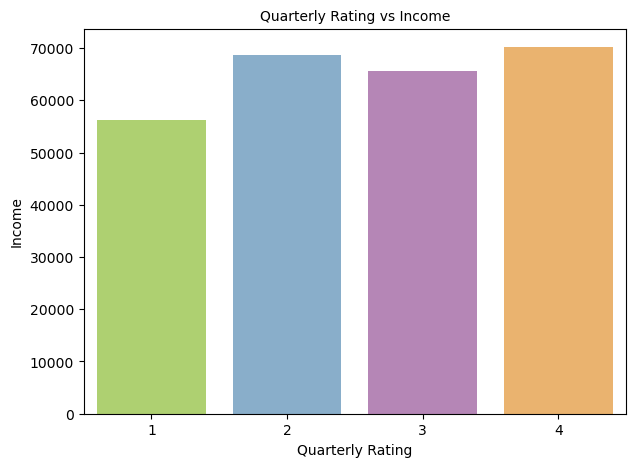

In [743]:
plt.figure(figsize=(7,5))
sns.barplot(data=final_df,x='Quarterly Rating',y='Income',ci=None)
plt.title('Quarterly Rating vs Income',fontsize=10)
plt.xlabel('Quarterly Rating',fontsize=10)
plt.ylabel('Income',fontsize=10)
plt.show()

City vs Total Business Value

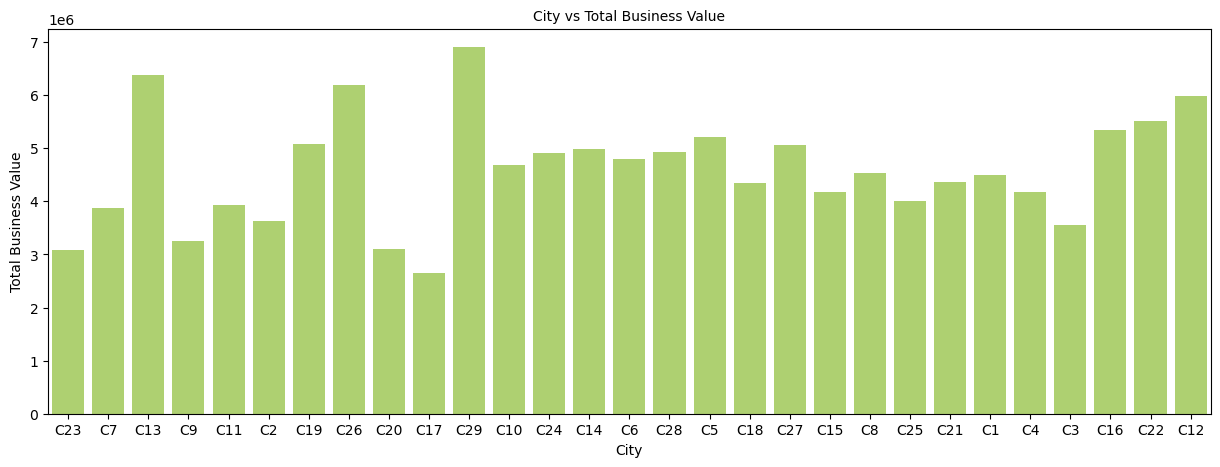

In [744]:
plt.figure(figsize=(15,5))
sns.barplot(data=final_df,x='City',y='Total Business Value',ci=None,color='#b2e061')
plt.title('City vs Total Business Value',fontsize=10)
plt.xlabel('City',fontsize=10)
plt.ylabel('Total Business Value',fontsize=10)
plt.show() 

City vs Income

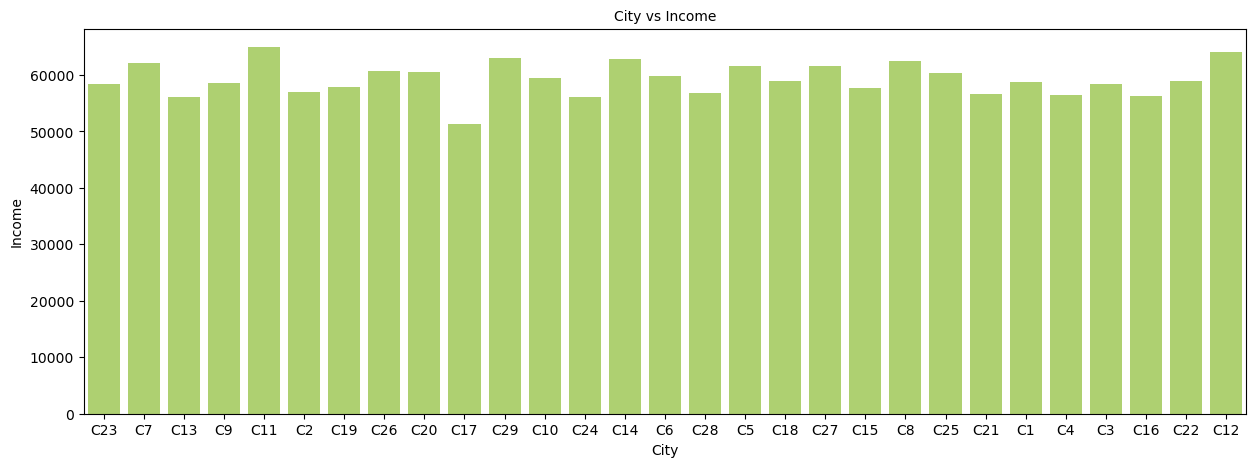

In [745]:
plt.figure(figsize=(15,5))
sns.barplot(data=final_df,x='City',y='Income',ci=None,color='#b2e061')
plt.title('City vs Income',fontsize=10)
plt.xlabel('City',fontsize=10)
plt.ylabel('Income',fontsize=10)
plt.show()

Transformation of columns for correlation plot:

In [746]:
final_df['Gender'].replace({'0':0,'1':1},inplace=True)

final_df['Churn'].replace({'0':0,'1':1},inplace=True)

final_df['Joining Designation']=final_df['Joining Designation'].astype(int)

final_df['Education_Level']=final_df['Education_Level'].astype(int)

final_df['Grade']=final_df['Grade'].astype(int)

final_df['ReportingCount']=final_df['ReportingCount'].astype(int)

final_df['rating_incr']=final_df['rating_incr'].astype(int)

final_df['income_incr']=final_df['income_incr'].astype(int)

final_df['Quarterly Rating']=final_df['Quarterly Rating'].astype(int)

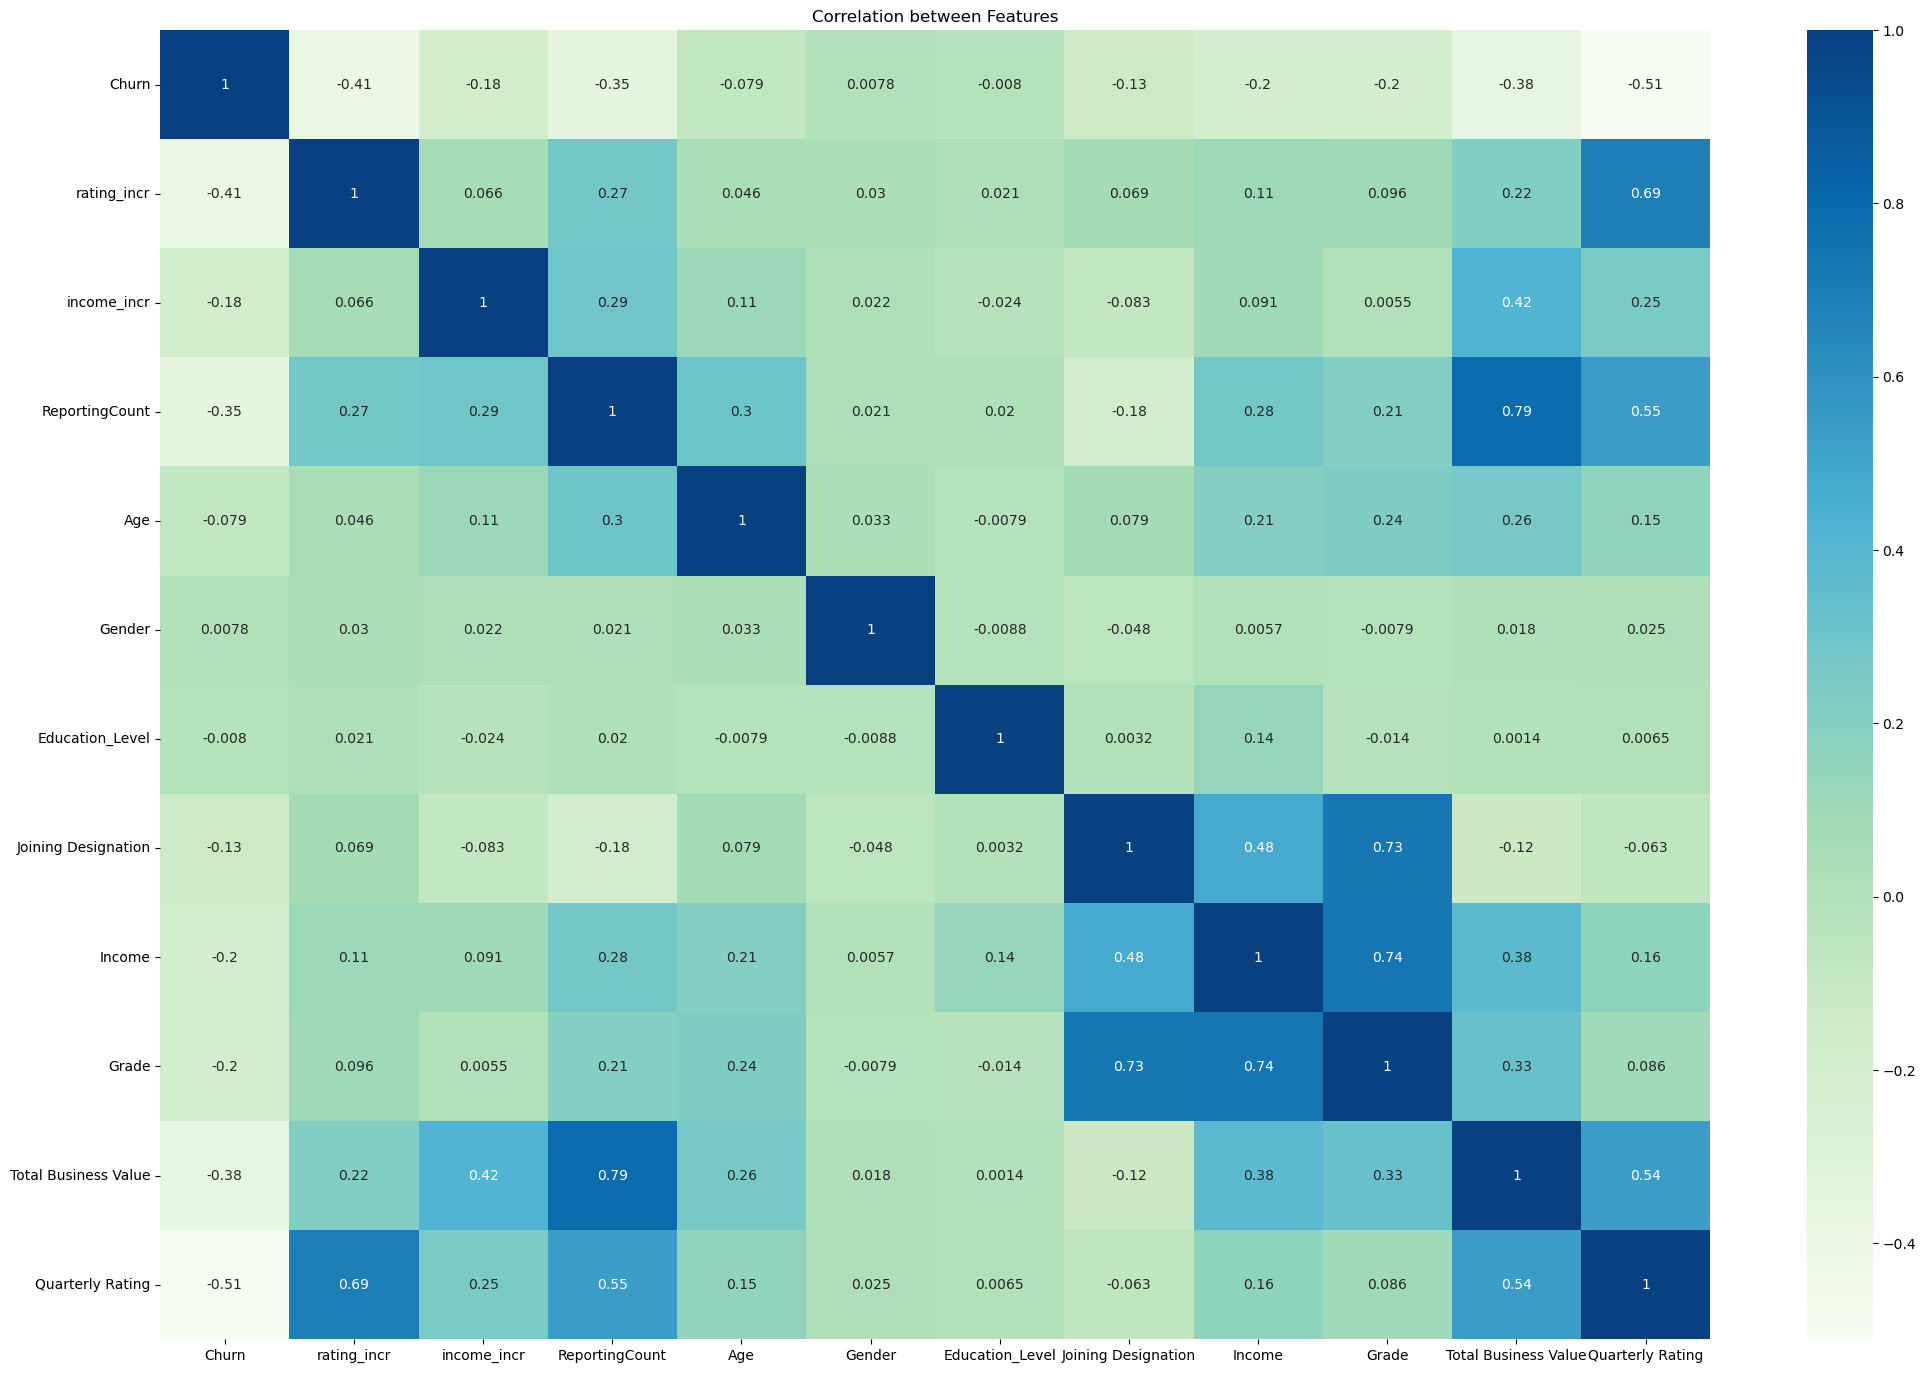

In [747]:
cat_cols=final_df.select_dtypes(include='number').columns
plt.figure(figsize=(25,17))
sns.heatmap(final_df.corr(), cmap="GnBu",annot=True)
plt.title('Correlation between Features')
plt.show() 

#### Insights:
- Income vs. Total Business Value: A high correlation here suggests that drivers who earn more also contribute more to Ola’s business. These individuals are likely high performers or operate in high-demand zones.
- Quarterly Rating vs. Rating Increase: Drivers with higher quarterly ratings tend to show rating improvements over time, reinforcing the idea that performance is consistent and cumulative.
- Income Increase vs. Churn (Negative): Drivers who experienced income growth are less likely to churn. This supports the insight that financial progression is a strong retention factor.
- Reporting Count vs. Churn: Moderate correlation may indicate that drivers with certain reporting frequencies (like 5 or 24) are more prone to churn, possibly due to operational stress or lack of engagement.
- Education Level vs. Churn: Very low correlation implies that educational background doesn’t significantly influence whether a driver stays or leaves.
- Gender vs. Churn: Minimal correlation suggests that while male drivers dominate the dataset, gender alone isn’t a strong predictor of churn—though it may still be relevant when combined with other factors.

#### Outliers

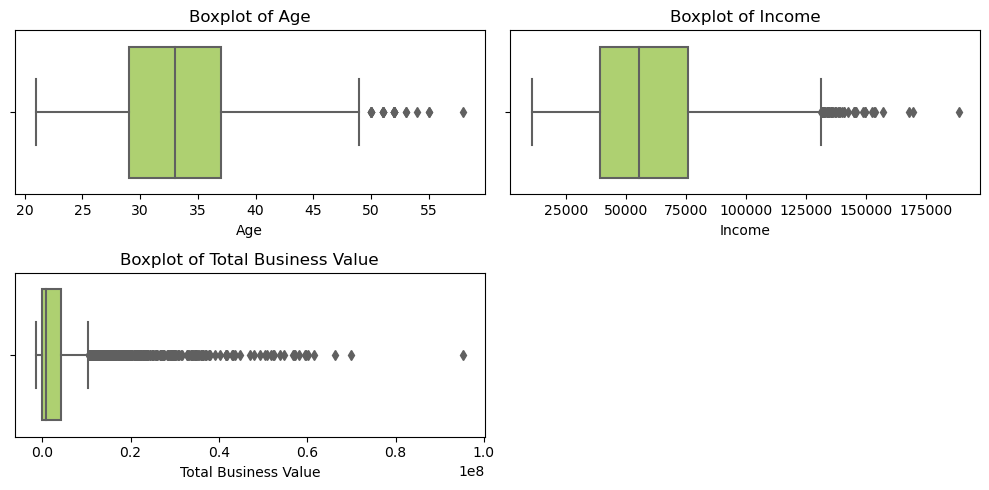

In [748]:
fig = plt.figure(figsize=(10,5))
i=1
for col in num_cols:
  ax = plt.subplot(2,2,i)
  sns.boxplot(x=final_df[col])
  plt.title(f'Boxplot of {col}')
  i += 1

plt.tight_layout()
plt.show()

Insights:

- Age: Very few outliers are present, mostly on the higher end (above 55), suggesting that older drivers are rare and may represent edge cases in recruitment.
- Income: Several high-income outliers are visible, indicating that a small subset of drivers earn significantly more than the average. These could be long-tenured drivers, top performers, or those operating in high-demand cities.
- Total Business Value: This shows extreme outliers, with values reaching up to very high values. These drivers likely contribute disproportionately to Ola’s revenue and should be considered strategic assets.
- On the lower end, some drivers have negative or zero business value, which may reflect operational losses or data anomalies.
- Given the limited dataset size, I have chosen to retain outliers in this analysis, as they may enhance model generalization and capture edge-case behavior more effectively.

### Data Preparation for Modelling

In [749]:
X = final_df.drop(columns=['Churn'])
y = final_df['Churn']
y = y.replace({'0': 0, '1': 1}).astype(int)

Dropping Date Columns

In [750]:
X.drop(columns=['LastWorkingDate','Dateofjoining'],inplace=True)

#### 1. Encoding of Categorical Columns

In [751]:
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
one_hot_encoded = encoder.fit_transform(X[['City']])
one_hot_df = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(['City']),index=X.index)

X = pd.concat([X,one_hot_df],axis=1)
X.drop(columns='City',axis=1,inplace=True)

In [752]:
print(X.shape)  # Should be (same number of rows, number of features)
print(y.shape)  

(2381, 40)
(2381,)


#### 2. Splitting into Train and Test Data

In [753]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

#### 3. Standardization

In [754]:
scaler=StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

#### 4. SMOTE for imbalanced data

In [755]:
y_train.value_counts(normalize=True)*100

1    68.644958
0    31.355042
Name: Churn, dtype: float64

In [756]:
sm=SMOTE(random_state=42)
X_train,y_train=sm.fit_resample(X_train,y_train)

In [757]:
y_train.value_counts(normalize=True)*100

1    50.0
0    50.0
Name: Churn, dtype: float64

### ### Ensemble Learning: Bagging (Random Forest Classfier)

In [758]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=42)


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300,400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'max_features': [4,7,10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1, verbose=2)
# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_bagging_model = grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 20, 'max_features': 7, 'min_samples_split': 2, 'n_estimators': 200}


In [759]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split= 2,
    max_features= 7,
    max_depth=20,
    random_state=42)

# Fit to training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=7, n_estimators=200,
                       random_state=42)

### Ensemble Learning: Boosting (LightGBM)

In [761]:
import lightgbm as lgb

# Initialize the base LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=lgb_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           verbose=2,
                           n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
best_lgb_model = grid_search.best_estimator_


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1307, number of negative: 1307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [762]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=15,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42)


# Fit to training data
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1307, number of negative: 1307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

LGBMClassifier(max_depth=5, num_leaves=15, random_state=42, subsample=0.8)

### Model Performance Evaluation

In [763]:
y_pred_rfm=pd.DataFrame(rf_model.predict(X_test))

y_pred_lgbm=pd.DataFrame(lgb_model.predict(X_test))

In [764]:
report_bagging=classification_report(y_test,y_pred_rfm)
report_boosting=classification_report(y_test,y_pred_lgbm)
print("Bagging Reports are: \n"+report_bagging)
print("Boosting Reports are: \n"+report_boosting)

Bagging Reports are: 
              precision    recall  f1-score   support

           0       0.78      0.63      0.70       168
           1       0.82      0.90      0.86       309

    accuracy                           0.81       477
   macro avg       0.80      0.77      0.78       477
weighted avg       0.80      0.81      0.80       477

Boosting Reports are: 
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       168
           1       0.83      0.90      0.86       309

    accuracy                           0.81       477
   macro avg       0.80      0.78      0.79       477
weighted avg       0.81      0.81      0.81       477



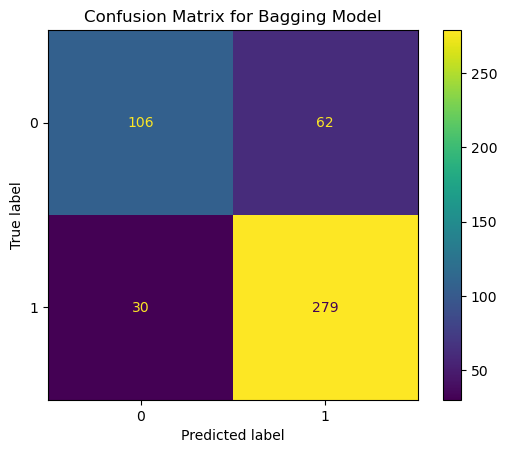

In [765]:
# Confusion Matrix for Bagging Model
cm = confusion_matrix(y_test, y_pred_rfm)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix for Bagging Model')
plt.show()

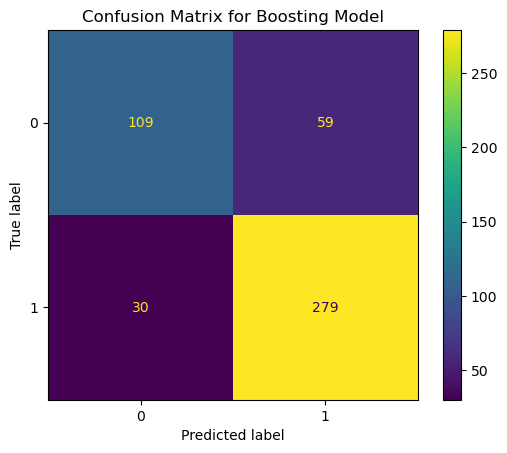

In [766]:
# Confusion Matrix for Boosting Model
cm = confusion_matrix(y_test, y_pred_lgbm)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix for Boosting Model')
plt.show()

### Model Interpretability

<function matplotlib.pyplot.show(close=None, block=None)>

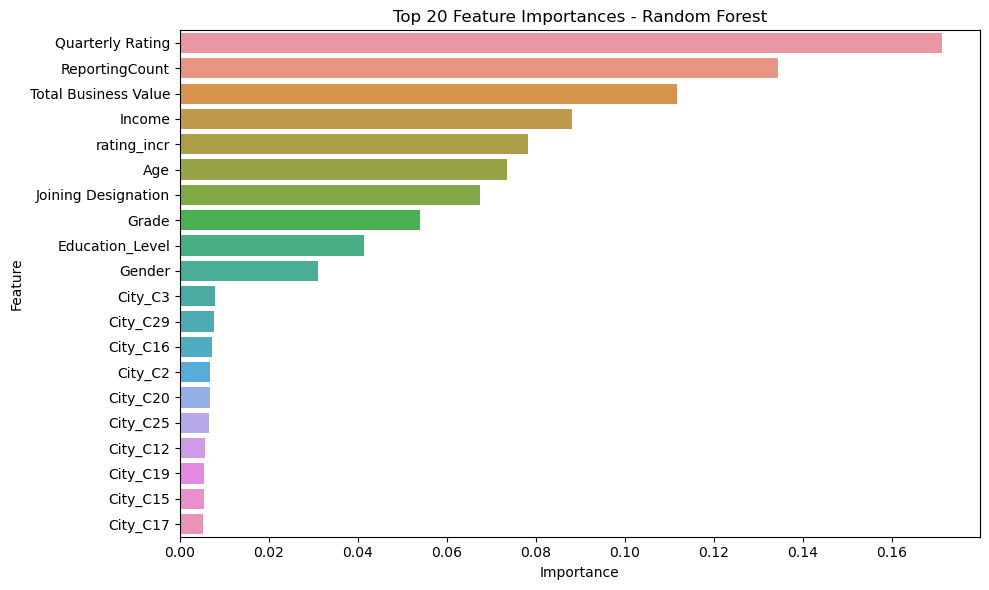

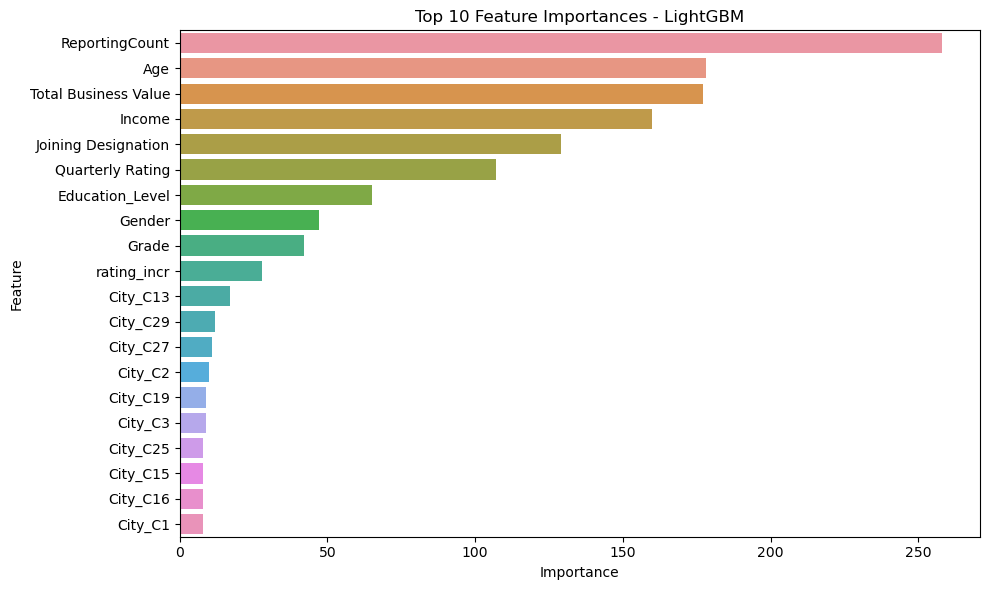

In [767]:
# Get feature importances
importances1 = rf_model.feature_importances_
importances2= lgb_model.feature_importances_
features = X_train.columns

# Create a DataFrame
importance_df1 = pd.DataFrame({
    'Feature': features,
    'Importance': importances1
}).sort_values(by='Importance', ascending=False)


# Create a DataFrame
importance_df2 = pd.DataFrame({
    'Feature': features,
    'Importance': importances2
}).sort_values(by='Importance', ascending=False)

# Plot for Random Forest Classifier
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df1.head(20))
plt.title("Top 20 Feature Importances - Random Forest")
plt.tight_layout()
plt.show

# Plot for LightGBM Classifier
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df2.head(20))
plt.title("Top 10 Feature Importances - LightGBM")
plt.tight_layout()
plt.show

### Comparison of ROC Curves & AUC Scores

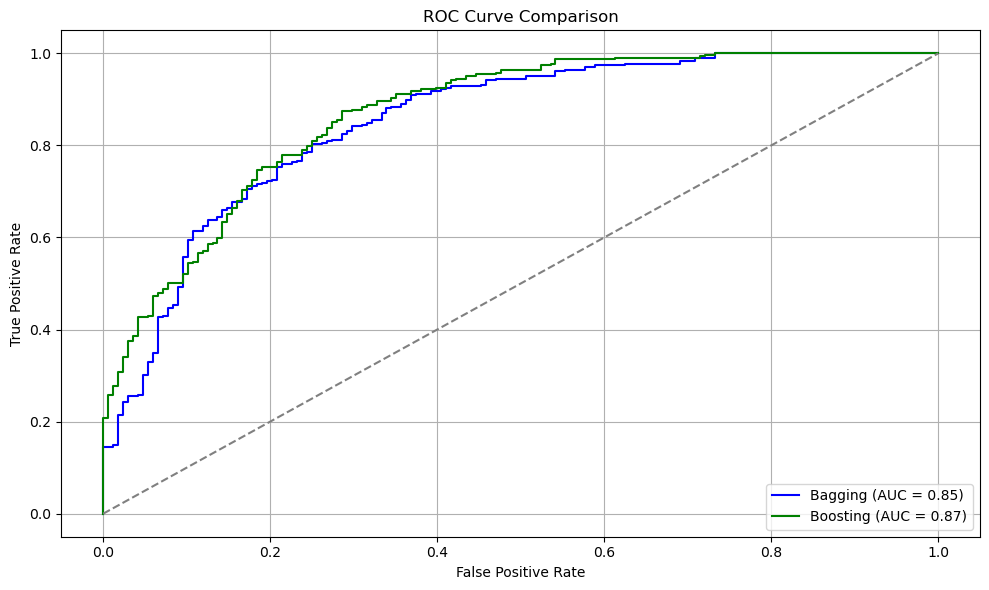

In [768]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_proba_bagging = rf_model.predict_proba(X_test)[:, 1]
y_proba_boosting = lgb_model.predict_proba(X_test)[:, 1] 

# Compute ROC curves
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_proba_bagging)
fpr_boosting, tpr_boosting, _ = roc_curve(y_test, y_proba_boosting)

# Compute AUC scores
auc_bagging = roc_auc_score(y_test, y_proba_bagging)
auc_boosting = roc_auc_score(y_test, y_proba_boosting)

# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_bagging, tpr_bagging, label=f'Bagging (AUC = {auc_bagging:.2f})', color='blue')
plt.plot(fpr_boosting, tpr_boosting, label=f'Boosting (AUC = {auc_boosting:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line

# Customize plot
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparison of Precision Recall Curves

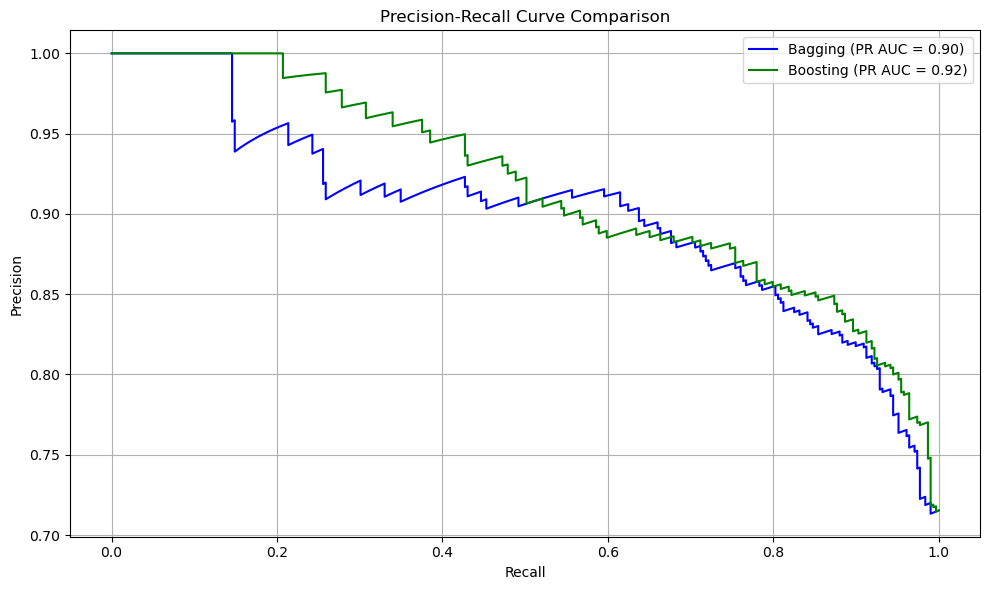

In [769]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall pairs
precision_bagging, recall_bagging, thresholds_bagging = precision_recall_curve(y_test, y_proba_bagging)
precision_boosting, recall_boosting, thresholds_boosting= precision_recall_curve(y_test, y_proba_boosting)

# Compute AUC for PR curves
pr_auc_bagging = auc(recall_bagging, precision_bagging)
pr_auc_boosting = auc(recall_boosting, precision_boosting)

# Plot both PR curves
plt.figure(figsize=(10, 6))
plt.plot(recall_bagging, precision_bagging, label=f'Bagging (PR AUC = {pr_auc_bagging:.2f})', color='blue')
plt.plot(recall_boosting, precision_boosting, label=f'Boosting (PR AUC = {pr_auc_boosting:.2f})', color='green')

# Customize plot
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Plotting Precison & Recall of both models at different Thresholds

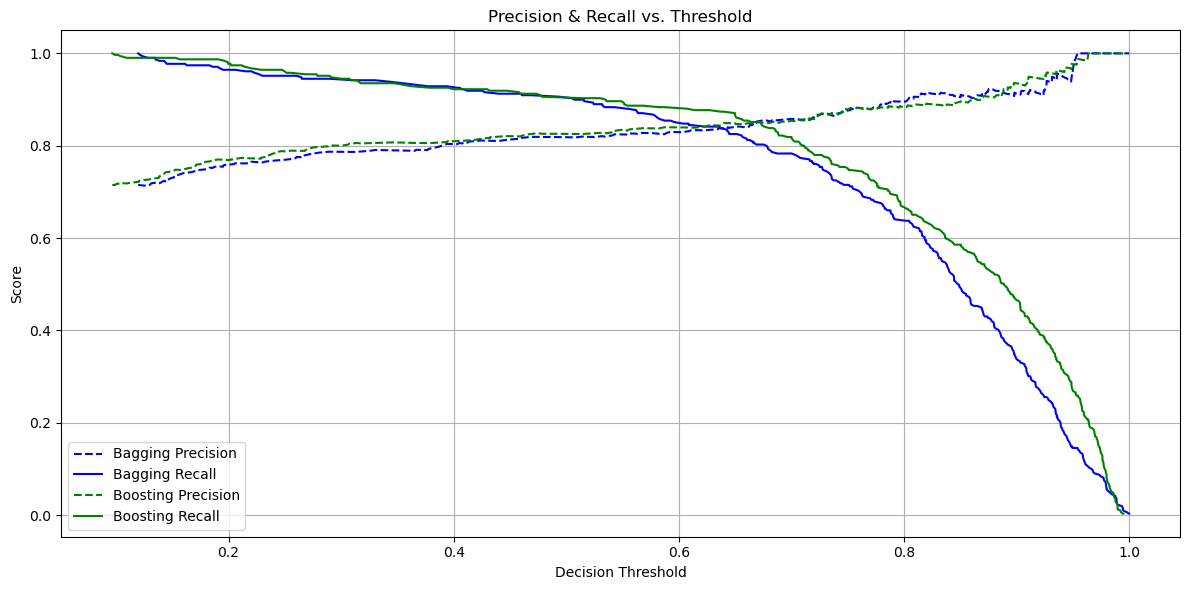

In [770]:
from sklearn.metrics import precision_recall_curve

# Plot precision and recall vs. threshold
plt.figure(figsize=(12, 6))

# Bagging
plt.plot(thresholds_bagging, precision_bagging[:-1], label='Bagging Precision', color='blue', linestyle='--')
plt.plot(thresholds_bagging, recall_bagging[:-1], label='Bagging Recall', color='blue')

# Boosting
plt.plot(thresholds_boosting, precision_boosting[:-1], label='Boosting Precision', color='green', linestyle='--')
plt.plot(thresholds_boosting, recall_boosting[:-1], label='Boosting Recall', color='green')

# Customize plot
plt.title('Precision & Recall vs. Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

Since the Boosting model demonstrates stronger performance in this case, the decision threshold will be selected based on its precision-recall curve.

Selected Threshold: 0.16
              precision    recall  f1-score   support

           0       0.94      0.40      0.57       168
           1       0.75      0.99      0.85       309

    accuracy                           0.78       477
   macro avg       0.85      0.70      0.71       477
weighted avg       0.82      0.78      0.75       477



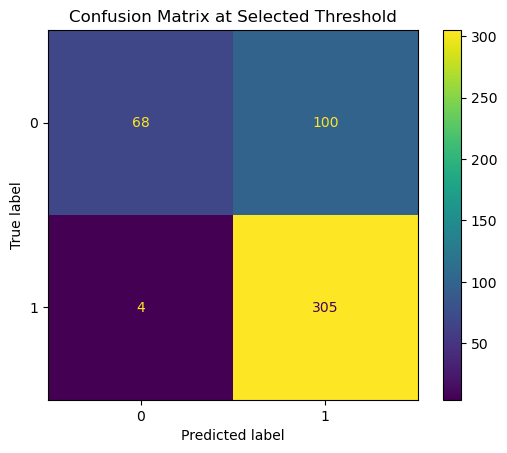

In [771]:
for p, r, t in zip(precision_boosting, recall_boosting, thresholds_boosting):
    if r > 0.85 and p > 0.75:
        selected_threshold = t
        break

# Apply threshold
y_pred_custom = (y_proba_boosting > selected_threshold).astype(int)

print(f"Selected Threshold: {selected_threshold:.2f}")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix at Selected Threshold")
plt.show()


#### Which metric to choose: Precision vs Recall:

- High Precision means that model has a very low rate of  false positives.This implies that the model does not incorrectly flag a lot of drivers at risk of churning who would have stayed. A high precision would be important to avoid wasting resources on incentives for drivers who would have stayed anyway.
- High recall means the model has a low rate of false negatives indicating that it does not miss a lot of drivers who are at the risk of churning.


For Ola, Recall is the more critical metric. A low recall means the company is failing to identify and retain a significant number of drivers,which is the core problem of this case study.For Ola, the cost of a false negative (losing an experienced driver) is likely much higher than the cost of a false positive (offering a small incentive to a driver who would have stayed).
Therefore the model should be optimized for a higher recall to ensure that drivers at the risk of churn are identified even if some non churners receive incentives unnnecessarily.

## Insights

- High Churn Rate: A substantial number of drivers have exited the platform, as indicated by the LastWorkingDate field. This underscores the need for focused retention strategies.

- Stagnant Growth Drives Attrition: Drivers who haven’t seen improvements in income or quarterly ratings are significantly more likely to churn. It’s clear that financial and performance stagnation are major contributors to exit behavior.

- Entry-Level Vulnerability: Those who joined at designation level 1 show the highest churn rates. This suggests that entry-level drivers may feel undervalued or lack upward mobility.

- Age Dynamics: Most drivers are in their early 30s, but churn is slightly higher among younger drivers—likely due to greater job mobility and responsiveness to competitive offers.

- Gender Imbalance: The workforce is predominantly male, and churn is higher among male drivers. This points to an opportunity for gender-sensitive engagement programs to improve retention and diversity.

- City C20 Hotspot: City C20 has the highest concentration of drivers and a notable churn rate. It may require localized retention strategies or operational review.

- Grade 2 Saturation: The majority of drivers fall into Grade 2, which also shows elevated churn. This could reflect a plateau in career progression or lack of performance recognition.

- Reporting Count Patterns: A reporting frequency of 5 is most common among churned drivers, followed by 24. These patterns may indicate workload stress or reporting fatigue.

- Income & Business Value Disparity: While a small group of drivers generate high income and business value, most remain in a modest bracket. Retaining high-value drivers is not just operationally important—it’s financially strategic.

- Boosting Outperforms Bagging: Both ensemble models performed well, but the boosting model (LightGBM) showed superior precision-recall balance. I recommend using this model to proactively identify and engage at-risk drivers.

- Key Predictors of Churn: Features like income increase, rating progression, total business value, and city emerged as the most influential variables. These should be monitored closely in real-time dashboards

## Recommendations:

- Deploy the boosting model to flag churn-risk drivers early and intervene with targeted retention efforts.

- Launch a targeted and differntiated incentive program that is directly linked to the insights from the churn prediction model based on declining earnings, low ratings, or high business value.

- Launch performance-based rewards—such as surge bonuses, achievement badges, and leaderboards—to motivate and retain top contributors.

- Introduce career pathing and incentive programs for Grade 2 and designation level 1 drivers to boost morale and progression.

- Implement gender-inclusive policies to diversify the workforce and reduce churn among male drivers.

- Design city-specific retention and recuitment strategies, especially for cities  like City C20.